In [1]:
library(data.table)
library(ggplot2)
library(reshape2)
library(tidyverse)
library(stringr)
library(heatmaply)
library(ape)
library(phylogram)
library(dendextend)
library(ComplexHeatmap)
library(RColorBrewer)
library(circlize)
library('stringr')
library(ggthemes)
library(ggpubr)
library(matrixStats)


Attaching package: ‘reshape2’


The following objects are masked from ‘package:data.table’:

    dcast, melt


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.7     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()

Loading required package: plotly


Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout


Loading required package: viridis

Loading r

In [2]:
lorikeet_funct <- function(a){
    
    a$attributes <- paste(a$attributes, ";", sep="")

    a$indels <- str_match(a$attributes, "indels=\\s*(.*?)\\s*;")[,2]
    a$rbs_spacer <- str_match(a$attributes, "rbs_spacer=\\s*(.*?)\\s*;")[,2]
    a$snps <- str_match(a$attributes, "snps=\\s*(.*?)\\s*;")[,2]
    a$dN_dS <- str_match(a$attributes, "indels=\\s*(.*?)\\s*;")[,2]
    a$start_type <- str_match(a$attributes, "start_type=\\s*(.*?)\\s*;")[,2]
    a$uscore <- str_match(a$attributes, "uscore=\\s*(.*?)\\s*;")[,2]
    a$partial <- str_match(a$attributes, "partial=\\s*(.*?)\\s*;")[,2]
    a$conf <- str_match(a$attributes, "conf=\\s*(.*?)\\s*;")[,2]
    a$bs_motif <- str_match(a$attributes, "bs_motif=\\s*(.*?)\\s*;")[,2]
    a$gc_cont <- str_match(a$attributes, "gc_cont=\\s*(.*?)\\s*;")[,2]
    a$cscore <- str_match(a$attributes, "cscore=\\s*(.*?)\\s*;")[,2]
    a$ID <- str_match(a$attributes, "ID=\\s*(.*?)\\s*;")[,2]
    a$score <- str_match(a$attributes, "score=\\s*(.*?)\\s*;")[,2]
    a$rscore <- str_match(a$attributes, "rscore=\\s*(.*?)\\s*;")[,2]
    a$tscore <- str_match(a$attributes, "tscore=\\s*(.*?)\\s*;")[,2]
    a$sscore <- str_match(a$attributes, "sscore=\\s*(.*?)\\s*;")[,2]
    
    a$indels <- sub('\\]', '', a$indels)
    a$indels <- sub('\\[', '', a$indels)
    
    a$snps <- sub('\\]', '', a$snps)
    a$snps <- sub('\\[', '', a$snps)
        
    a$indels <- sub('\\]', '', a$indels)
    a$indels <- sub('\\[', '', a$indels)

    a2 <- subset(a, select=-c(attributes))
    
    return(a2)
}

prok_funct <- function(b){
    
    b$attributes <- paste(b$attributes, ";", sep="")
    b$ID <- str_match(b$attributes, "ID=\\s*(.*?)\\s*;")[,2]
    b$inference <- str_match(b$attributes, "inference=\\s*(.*?)\\s*;")[,2]
    b$locus_tag <- str_match(b$attributes, "locus_tag=\\s*(.*?)\\s*;")[,2]
    b$product <- str_match(b$attributes, "product=\\s*(.*?)\\s*;")[,2]

    b2 <- subset(b, select=-c(attributes))
    
    return(b2)
}

common_variables <- c('seqid','start','end','strand', 'phase')

In [3]:
# function to make the wide snps matricies 

split_function <- function(snps, tsv){ 
    colnames(snps) <- c(1:208,"locus_tag")
    snps3 <- merge(snps, tsv, by="locus_tag", all.y=FALSE)

    snps3$gene_loc <- paste(snps3$locus_tag, snps3$gene)
    snps4 <- snps3 %>% remove_rownames %>% column_to_rownames(var="gene_loc")
    snps5 <- snps4[,2:209]

    snps5$mean <- apply(snps5, 1, mean, na.rm=TRUE)
    snps5$min <- rowMins(as.matrix(snps5[,2:209]))
    snps5$max <- rowMaxs(as.matrix(snps5[,2:209]))

    
    return(snps5)
}

In [4]:
#import the ko enrichm file 

ko <- fread('/work/microbiome/abisko/eilish/09_methanoflorens/references/2022-05-09_09-29-enrichm_annotate_output/annotations_ko/DIAMOND_search.tsv')
ko2 <- data.frame(do.call('rbind', strsplit(as.character(ko$V1),'~',fixed=TRUE)))
ko3 <- data.frame(do.call('rbind', strsplit(as.character(ko$V2),'~',fixed=TRUE)))
ko4 <- cbind(ko2,ko3)
ko4 <- cbind(ko4, ko[,3:12])

colnames(ko4)[1:4] <- c("genome",
                "locus_tag",
                "uniref",
                "ko")
ko5 <- ko4[,1:4]


In [5]:
# importing metadata
metadata <- fread("/work/microbiome/abisko/eilish/09_methanoflorens/20220504_ani_metadata.tsv") # read in metadata with ANIs calculated in other jupyter
metadata$type <- metadata$type %>% replace_na('none')
metadata$location <- metadata$location %>% replace_na('Other')

# making the annotations for the heatmaps

location = HeatmapAnnotation(Location = metadata$location,
    col = list(Location = c('Chersky'='#8DD3C7',
                       'Other'='white',
                       'Alaska'='#80B1D3',
                       'Marcell'='#B3DE69',
                       'Loxahatchee'='#FDB462',
                       'Abisko'='#FB8072')))

subhab = HeatmapAnnotation(Subhabitat = metadata$type,
    col = list(Subhabitat = c('none'='white',
                       'Palsa'='#2B83BA',
                       'Bog'='#FDAE61',
                       'Fen'='#D7191C')))

col_fun = colorRamp2(c(0,10,20), c("white", "red", "black"))
col_fun2 = colorRamp2(c(1,6), c("white", "red"))
col_fun3 = colorRamp2(c(0,1,6), c("blue", "white", "red"))


In [6]:
# function for plotting heatmaps

heatmap_function <- function(df, colours, title){
    plot <- Heatmap(df, col=colours,
                    name = "indels", #title of legend
                    row_names_gp = gpar(fontsize = 10),
                    column_names_gp = gpar(fontsize = 6),
                    bottom_annotation = c(subhab,location),
                    row_names_max_width = unit(15, "cm"),
                    border_gp = gpar(col = "black", lty = 2),
                    column_title={{title}} 
               )
    return(plot)
    }

Warning message:
“The input is a data frame, convert it to a matrix.”


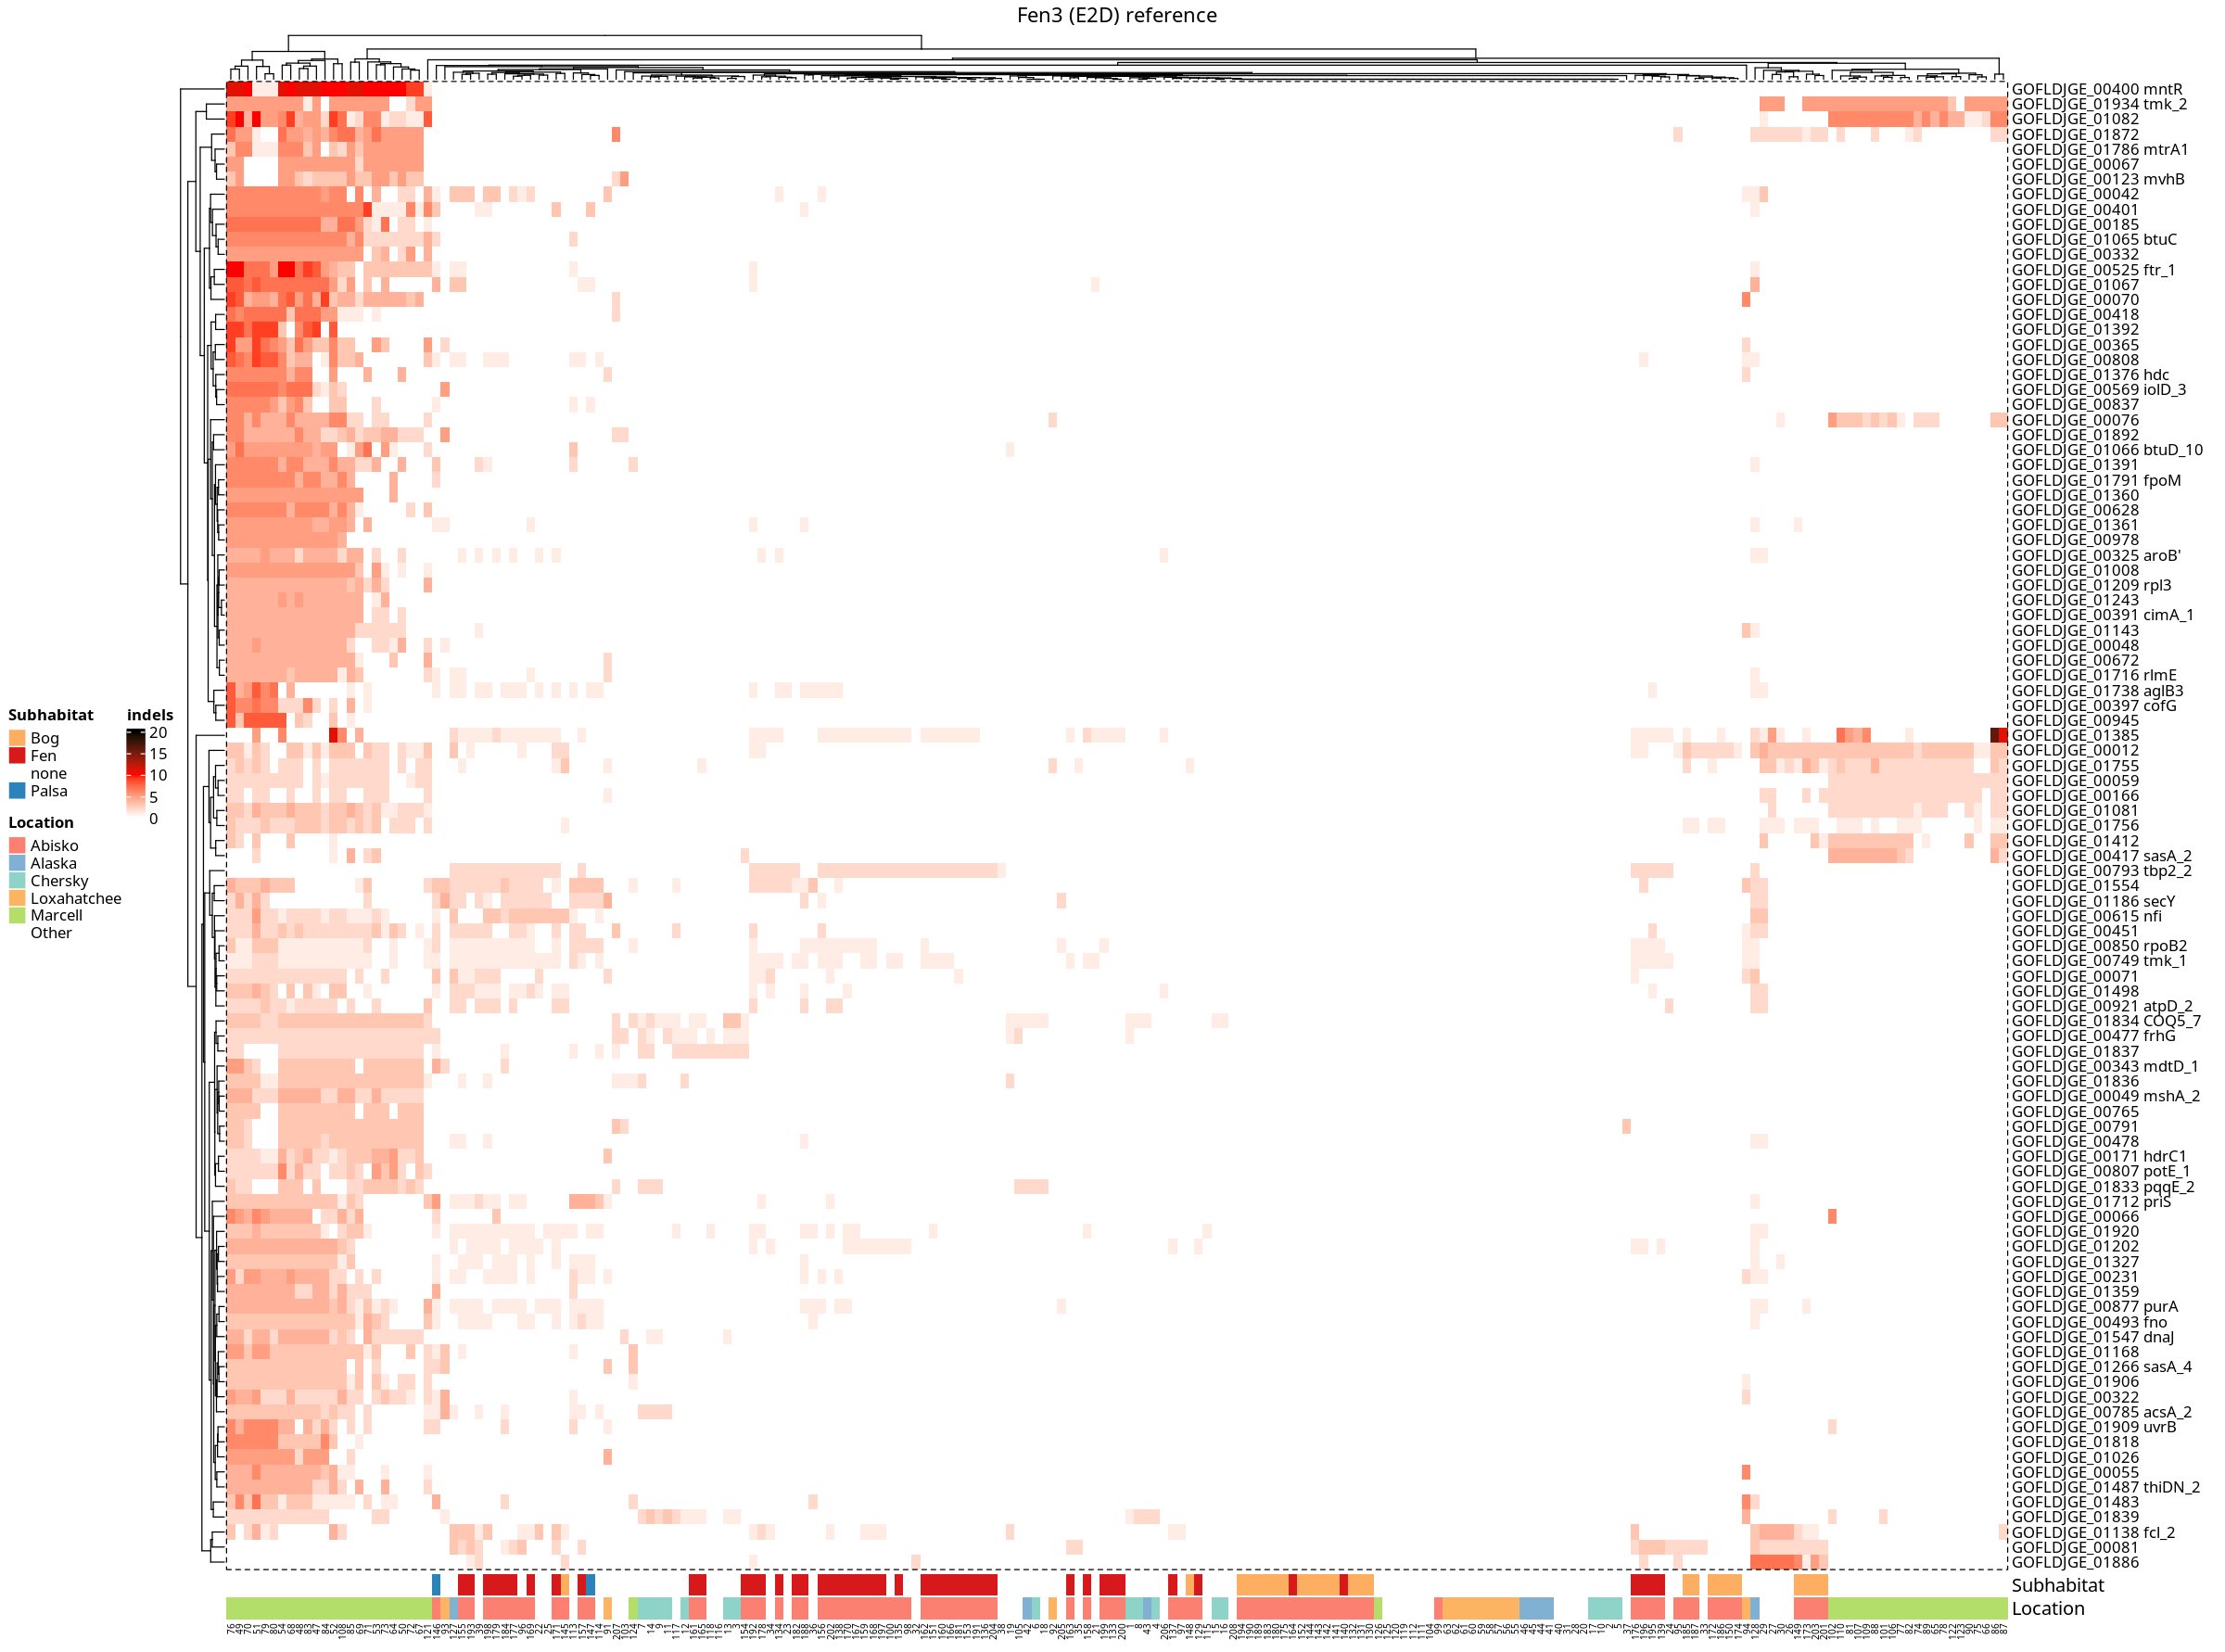

In [7]:
# full process dor e2d

prok_e2d <- read.gff('/work/microbiome/abisko/eilish/09_methanoflorens/references/prokka_e2d/clean_20100900_E2D.gff')
lor_e2d <- read.gff('/work/microbiome/abisko/eilish/09_methanoflorens/00-lorikeet_call/GCA_003162175.1_20100900_E2D_genomic/GCA_003162175.1_20100900_E2D_genomic.gff')
e2d_tsv <- fread('/work/microbiome/abisko/eilish/09_methanoflorens/references/prokka_e2d/prokka_e2d.tsv')

lorikeet_e2d <- lorikeet_funct(lor_e2d)
prokka_e2d <- prok_funct(prok_e2d)

comb_e2d <- merge(lorikeet_e2d, prokka_e2d, by=common_variables, all=FALSE) 

e2d_indels <- data.frame(do.call('rbind', strsplit(as.character(comb_e2d$indels),',',fixed=TRUE)))
e2d_indels <- mutate_all(e2d_indels, function(x) as.numeric(as.character(x)))
e2d_indels$locus_tag <- comb_e2d$locus_tag
                       
e2d_indels_filt <- e2d_indels 
#                          %>% 
#     rowwise %>% 
#     filter(sum(c_across(where(is.numeric))) != 208) %>%
#     ungroup
                         

e2d_matrix <- split_function(e2d_indels, e2d_tsv)
upper_boundary_e2d <- mean(e2d_matrix$mean)+(2*sd(e2d_matrix$mean))                         
e2d_low <- subset(e2d_matrix, mean>upper_boundary_e2d)[,1:208]
                       
e2d_all <- e2d_matrix[,1:208]
                       
# h1 <- 0.05*nrow(e2d_all)
# options(repr.plot.width=20, repr.plot.height=h1)
# hma <- heatmap_function(e2d_all, col_fun,"Fen3 (E2D) reference")
# draw(hma, heatmap_legend_side = "left", annotation_legend_side = "left")
                       
h1 <- 0.15*nrow(e2d_low)
options(repr.plot.width=20, repr.plot.height=h1)
hma <- heatmap_function(e2d_low, col_fun,"Fen3 (E2D) reference")
draw(hma, heatmap_legend_side = "left", annotation_legend_side = "left")

Warning message:
“The input is a data frame, convert it to a matrix.”


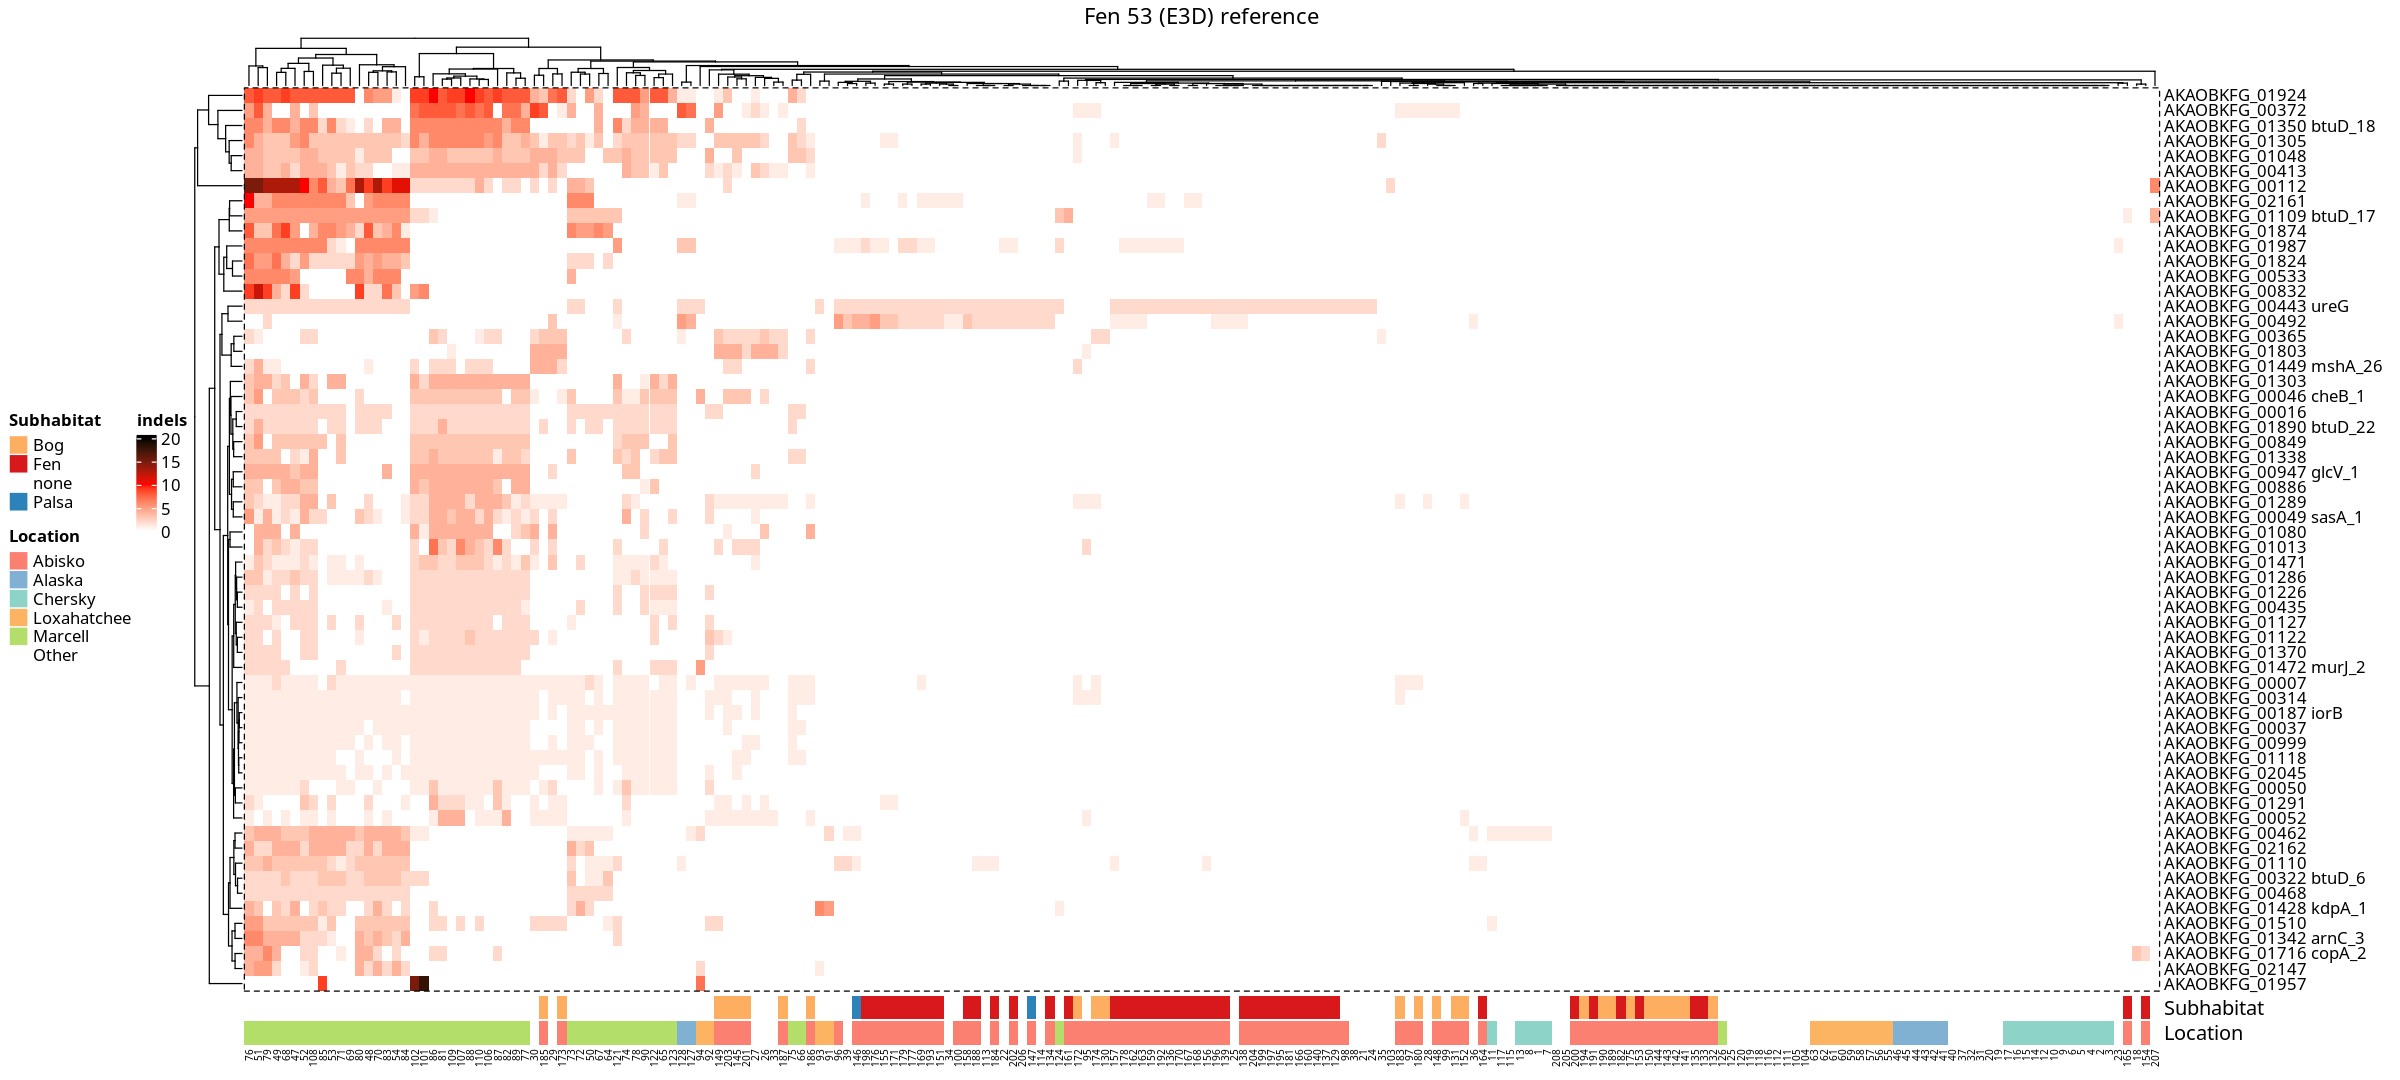

In [8]:
# full process dor e3d

prok_e3d <- read.gff('/work/microbiome/abisko/eilish/09_methanoflorens/references/prokka_e3d/clean_20120600_E3D.gff')
lor_e3d <- read.gff('/work/microbiome/abisko/eilish/09_methanoflorens/00-lorikeet_call/GCA_003158275.1_20120600_E3D_genomic/GCA_003158275.1_20120600_E3D_genomic.gff')
e3d_tsv <- fread('/work/microbiome/abisko/eilish/09_methanoflorens/references/prokka_e3d/prokka_e3d.tsv')

lorikeet_e3d <- lorikeet_funct(lor_e3d)
prokka_e3d <- prok_funct(prok_e3d)

comb_e3d <- merge(lorikeet_e3d, prokka_e3d, by=common_variables, all=FALSE) 

e3d_indels <- data.frame(do.call('rbind', strsplit(as.character(comb_e3d$indels),',',fixed=TRUE)))
e3d_indels <- mutate_all(e3d_indels, function(x) as.numeric(as.character(x)))
e3d_indels$locus_tag <- comb_e3d$locus_tag
                       
e3d_indels_filt <- e3d_indels 
#                          %>% 
#     rowwise %>% 
#     filter(sum(c_across(where(is.numeric))) != 208) %>%
#     ungroup

e3d_matrix <- split_function(e3d_indels, e3d_tsv)
upper_boundary_e3d <- mean(e3d_matrix$mean)+(2*sd(e3d_matrix$mean))                         
e3d_low <- subset(e3d_matrix, mean>upper_boundary_e3d)[,1:208]
e3d_all <- e3d_matrix[,1:208]
                       
# h1 <- 0.05*nrow(e3d_all)
# options(repr.plot.width=20, repr.plot.height=h1)
# hma <- heatmap_function(e3d_all, col_fun,"Fen3 (E2D) reference")
# draw(hma, heatmap_legend_side = "left", annotation_legend_side = "left")
                       
h1 <- 0.15*nrow(e3d_low)
options(repr.plot.width=20, repr.plot.height=h1)
hma <- heatmap_function(e3d_low, col_fun, "Fen 53 (E3D) reference")
draw(hma, heatmap_legend_side = "left", annotation_legend_side = "left")

Warning message:
“The input is a data frame, convert it to a matrix.”


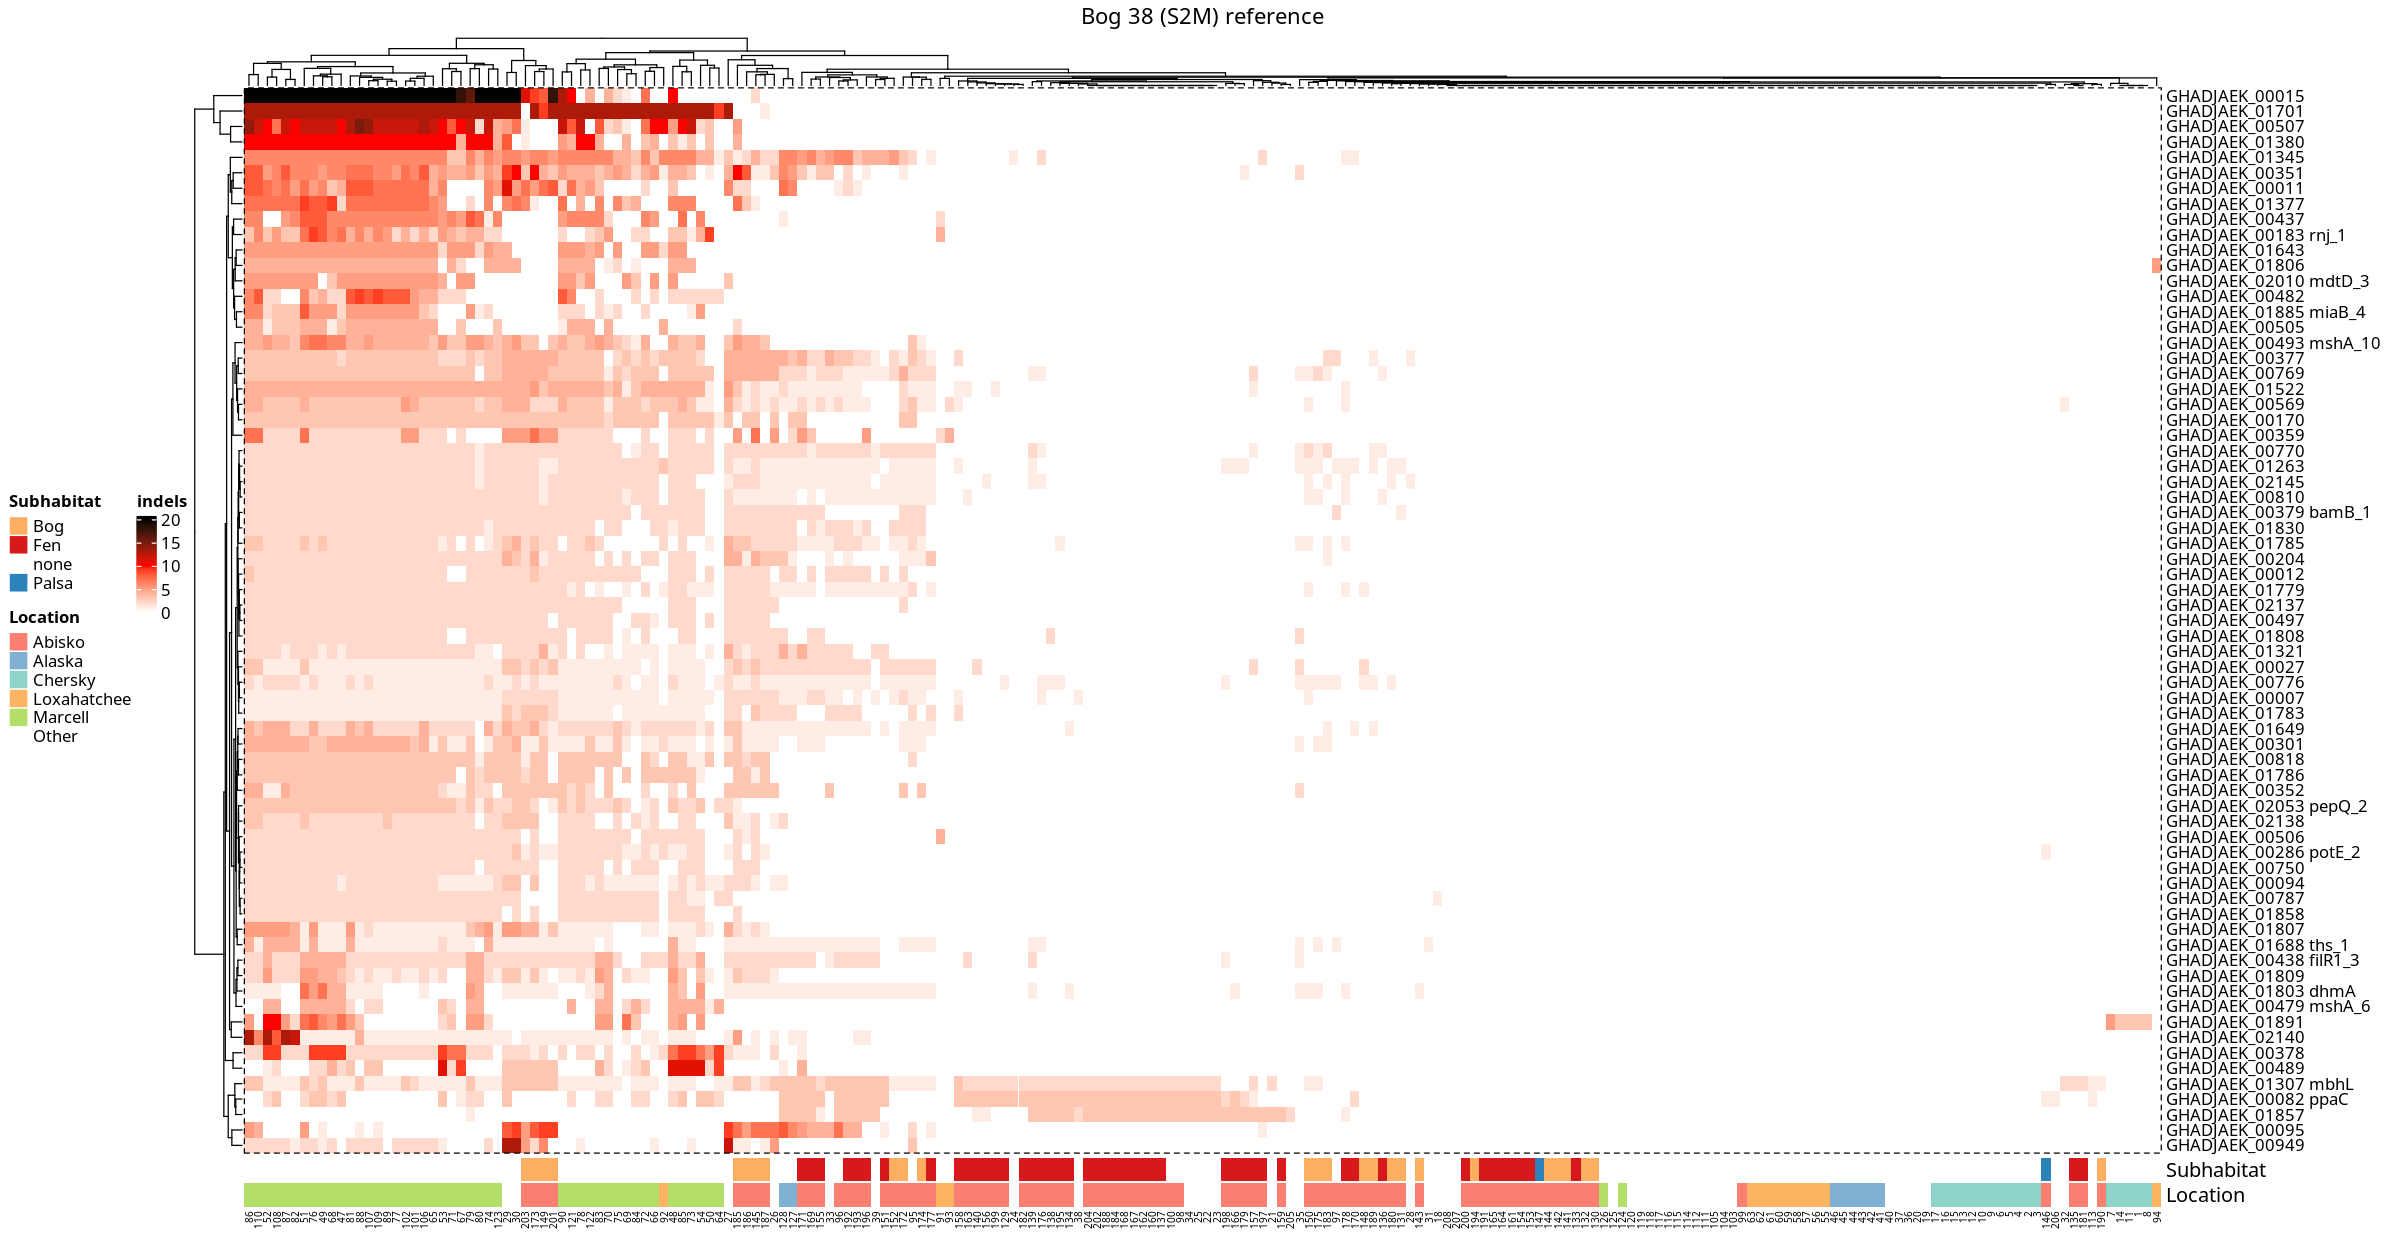

In [9]:
# full process dor s2m

prok_s2m <- read.gff('/work/microbiome/abisko/eilish/09_methanoflorens/references/prokka_s2m/clean_20110800_S2M.gff')
lor_s2m <- read.gff('/work/microbiome/abisko/eilish/09_methanoflorens/00-lorikeet_call/GCA_003139855.1_20110800_S2M_genomic/GCA_003139855.1_20110800_S2M_genomic.gff')
s2m_tsv <- fread('/work/microbiome/abisko/eilish/09_methanoflorens/references/prokka_s2m/prokkas2m.tsv')

lorikeet_s2m <- lorikeet_funct(lor_s2m)
prokka_s2m <- prok_funct(prok_s2m)

comb_s2m <- merge(lorikeet_s2m, prokka_s2m, by=common_variables, all=FALSE) 

s2m_indels <- data.frame(do.call('rbind', strsplit(as.character(comb_s2m$indels),',',fixed=TRUE)))
s2m_indels <- mutate_all(s2m_indels, function(x) as.numeric(as.character(x)))
s2m_indels$locus_tag <- comb_s2m$locus_tag
                       
s2m_indels_filt <- s2m_indels 
#                          %>% 
#     rowwise %>% 
#     filter(sum(c_across(where(is.numeric))) != 208) %>%
#     ungroup

                         
s2m_matrix <- split_function(s2m_indels, s2m_tsv)
upper_boundary_s2m <- mean(s2m_matrix$mean)+(2*sd(s2m_matrix$mean))  
s2m_low <- subset(s2m_matrix, mean>upper_boundary_s2m)[,1:208]
s2m_all <- s2m_matrix[,1:208]
                       
# h1 <- 0.05*nrow(s2m_all)
# options(repr.plot.width=20, repr.plot.height=h1)
# hma <- heatmap_function(s2m_all, col_fun,"Fen3 (E2D) reference")
# draw(hma, heatmap_legend_side = "left", annotation_legend_side = "left")
                       
h1 <- 0.15*nrow(s2m_low)
options(repr.plot.width=20, repr.plot.height=h1)
hma <- heatmap_function(s2m_low, col_fun, "Bog 38 (S2M) reference")
draw(hma, heatmap_legend_side = "left", annotation_legend_side = "left")

In [10]:
length(intersect(e2d_matrix$ko, e3d_matrix$ko))
length(intersect(e2d_matrix$ko, s2m_matrix$ko))
length(intersect(s2m_matrix$ko, e3d_matrix$ko))


length(e2d_matrix$ko)
length(e3d_matrix$ko)
length(s2m_matrix$ko)


[1] 0

[1] 0

[1] 0

[1] 0

[1] 0

[1] 0

In [11]:
head(e2d_matrix)

1 2 3 4 5 6 7 8 9 10 ⋯ 202 203 204 205 206 207 208 mean       
GOFLDJGE_00002  0 0 0 0 0 0 0 0 0 0  ⋯ 0   0   0   0   0   0   0   0.009615385
GOFLDJGE_00003  0 0 0 0 0 0 0 0 0 0  ⋯ 0   0   0   0   0   0   0   0.000000000
GOFLDJGE_00004  0 0 0 0 0 0 0 0 0 0  ⋯ 0   0   0   0   0   0   0   0.000000000
GOFLDJGE_00005  0 0 0 0 0 0 0 0 0 0  ⋯ 0   0   0   0   0   0   0   0.000000000
GOFLDJGE_00007  0 0 0 0 0 0 0 0 0 0  ⋯ 0   0   0   0   0   0   0   0.000000000
GOFLDJGE_00009  0 0 0 0 0 0 0 0 0 0  ⋯ 0   0   0   0   0   0   0   0.000000000
                min max
GOFLDJGE_00002  0   1  
GOFLDJGE_00003  0   0  
GOFLDJGE_00004  0   0  
GOFLDJGE_00005  0   0  
GOFLDJGE_00007  0   0  
GOFLDJGE_00009  0   0

In [25]:
#functions for mcr

heatmap_function2 <- function(df, colours,title){
    plot <- Heatmap(df, col=colours,
                name = "Indels", #title of legend
                row_names_gp = gpar(fontsize = 10),
                column_names_gp = gpar(fontsize = 6),
                row_names_max_width = unit(15, "cm"),
                border_gp = gpar(col = "black", lty = 2),
                row_title={{title}},  
                cluster_rows = FALSE,
                cluster_columns = FALSE
               )
    return(plot)
    }

heatmap_function3 <- function(df, colours, title){
    plot <- Heatmap(df, col=colours,
                    name = "Indels", #title of legend
                    row_names_gp = gpar(fontsize = 10),
                    column_names_gp = gpar(fontsize = 6),
                    bottom_annotation = c(subhab,location),
                    row_names_max_width = unit(15, "cm"),
                    border_gp = gpar(col = "black", lty = 2),
                    row_title={{title}}, cluster_rows = FALSE,cluster_columns = FALSE
                    
               )
    return(plot)
    }

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 1060 rows containing non-finite values (stat_bin).”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 1571 rows containing non-finite values (stat_bin).”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 1604 rows containing non-finite values (stat_bin).”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 22 rows containing missing values (geom_bar).”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 19 rows containing missing values (geom_bar).”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 15 rows containing missing values (geom_bar).”


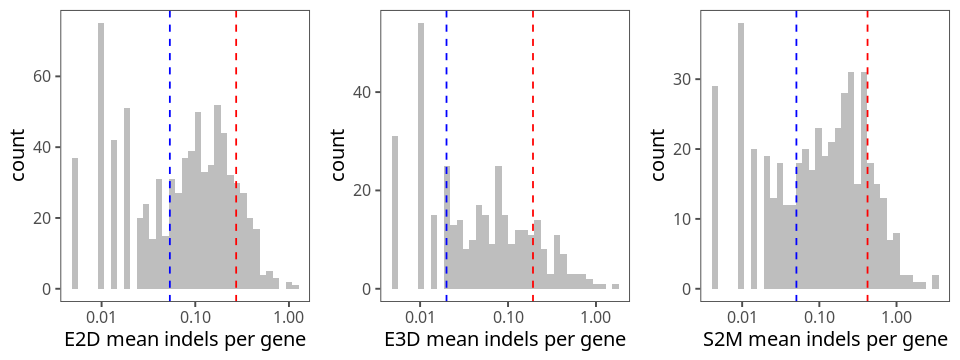

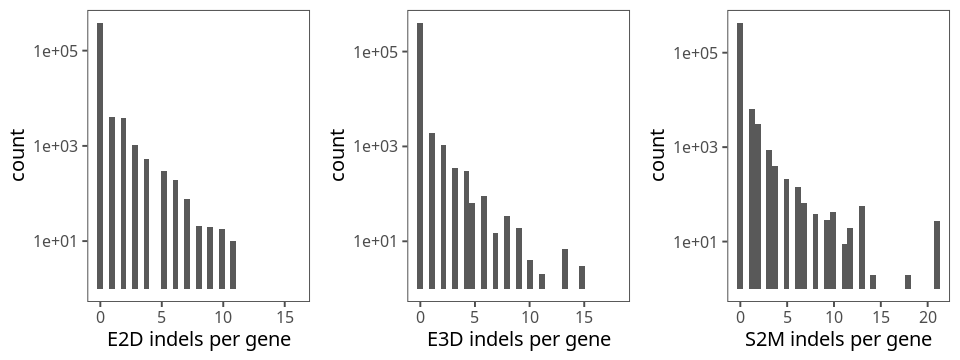

In [26]:
e2d_long <- melt(setDT(e2d_indels_filt), id.vars = "locus_tag", variable.name = "sample", value.name="indels")
e2d_long$indels <- as.numeric(e2d_long$indels)

s2m_long <- melt(setDT(s2m_indels_filt), id.vars = "locus_tag", variable.name = "sample", value.name="indels")
s2m_long$indels <- as.numeric(s2m_long$indels)

e3d_long <- melt(setDT(e3d_indels_filt), id.vars = "locus_tag", variable.name = "sample", value.name="indels")
e3d_long$indels <- as.numeric(e3d_long$indels)

a <- ggplot(e2d_matrix, aes(mean))+geom_histogram(bins=35, fill="grey")+
        theme_few()+xlab("E2D mean indels per gene")+scale_x_log10()+
        geom_vline(xintercept=mean(e2d_matrix$mean), color="blue", linetype="dashed")+
        geom_vline(xintercept=upper_boundary_e2d, color='red', linetype="dashed")

b <- ggplot(e3d_matrix, aes(mean))+geom_histogram(bins=35, fill="grey")+
        theme_few()+xlab("E3D mean indels per gene")+scale_x_log10()+
        geom_vline(xintercept=mean(e3d_matrix$mean), color="blue", linetype="dashed")+
        geom_vline(xintercept=upper_boundary_e3d, color='red', linetype="dashed")

c <- ggplot(s2m_matrix, aes(mean))+geom_histogram(bins=35, fill="grey")+
        theme_few()+xlab("S2M mean indels per gene")+scale_x_log10()+
        geom_vline(xintercept=mean(s2m_matrix$mean), color="blue", linetype="dashed")+
        geom_vline(xintercept=upper_boundary_s2m, color='red', linetype="dashed")

options(repr.plot.width=8, repr.plot.height=3)
ggarrange(a,b,c, ncol=3)

a <- ggplot(e2d_long, aes(indels))+geom_histogram(bins=35)+
        theme_few()+xlab("E2D indels per gene")+scale_y_log10()
b <- ggplot(e3d_long, aes(indels))+geom_histogram(bins=35)+
        theme_few()+xlab("E3D indels per gene")+scale_y_log10()
c <- ggplot(s2m_long, aes(indels))+geom_histogram(bins=35)+
        theme_few()+xlab("S2M indels per gene")+scale_y_log10()

options(repr.plot.width=8, repr.plot.height=3)
ggarrange(a,b,c, ncol=3)

Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“Heatmap/annotation names are duplicated: Indels”
Warning message:
“Heatmap/annotation names are duplicated: Indels, Indels”


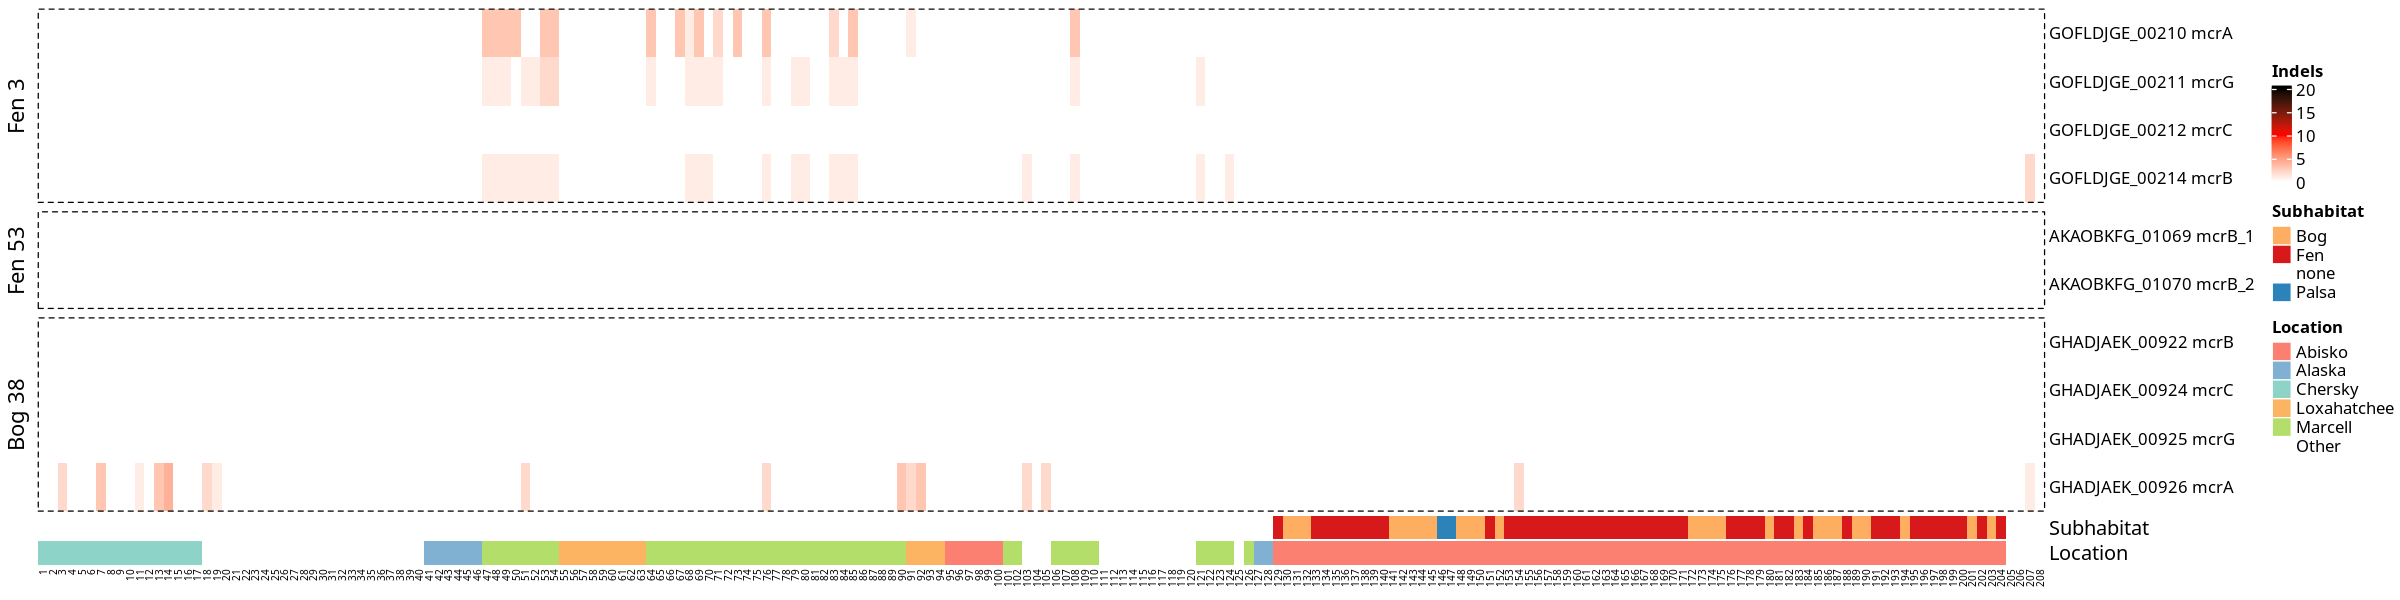

In [27]:
# MCR 

t1 <- split_function(e2d_indels, e2d_tsv)
t2 <- split_function(e3d_indels, e3d_tsv)
t3 <- split_function(s2m_indels, s2m_tsv)

mcr1 <- t1[grep("mcr", rownames(t1)), ][,1:208]
mcr2 <- t2[grep("mcr", rownames(t2)), ][,1:208]
mcr3 <- t3[grep("mcr", rownames(t3)), ][,1:208]


hma1 <- heatmap_function2(mcr1, col_fun, "Fen 3")
hma2 <- heatmap_function2(mcr2, col_fun,"Fen 53")
hma3 <- heatmap_function3(mcr3, col_fun, "Bog 38")


options(repr.plot.width=20, repr.plot.height=5)

sexy_list <- hma1%v%hma2%v%hma3

draw(sexy_list)

Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”


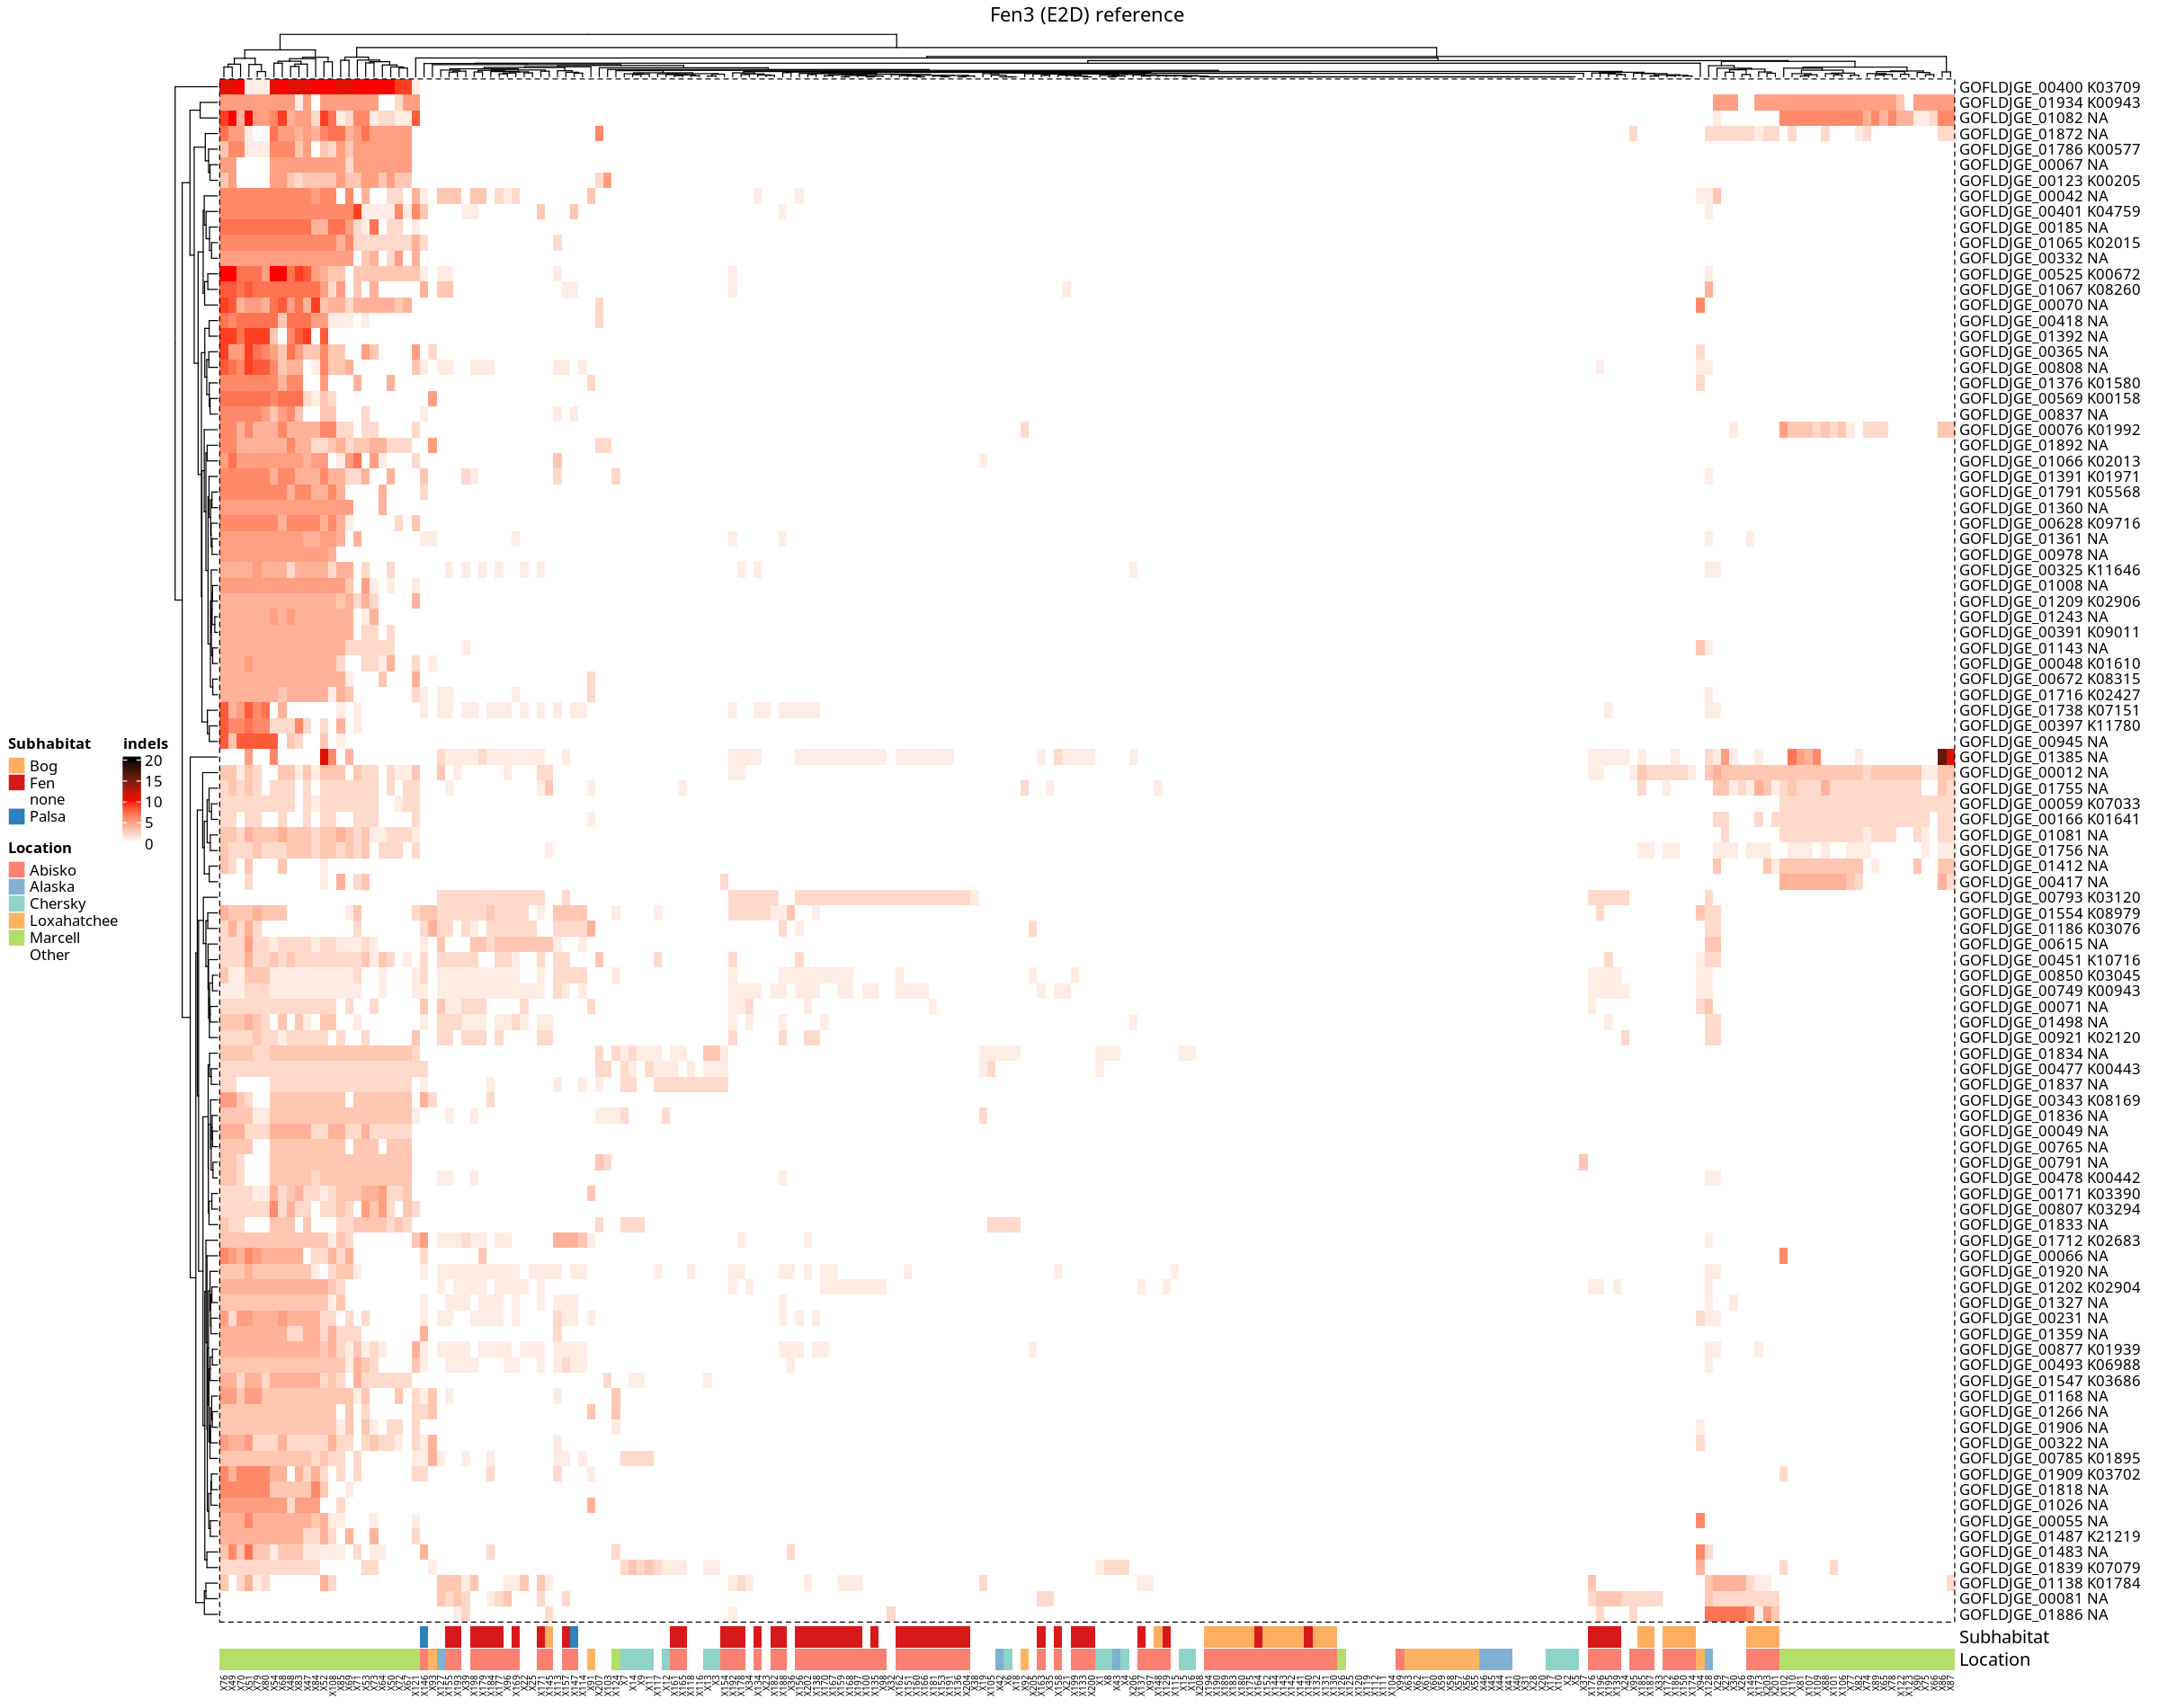

Warning message:
“The input is a data frame, convert it to a matrix.”


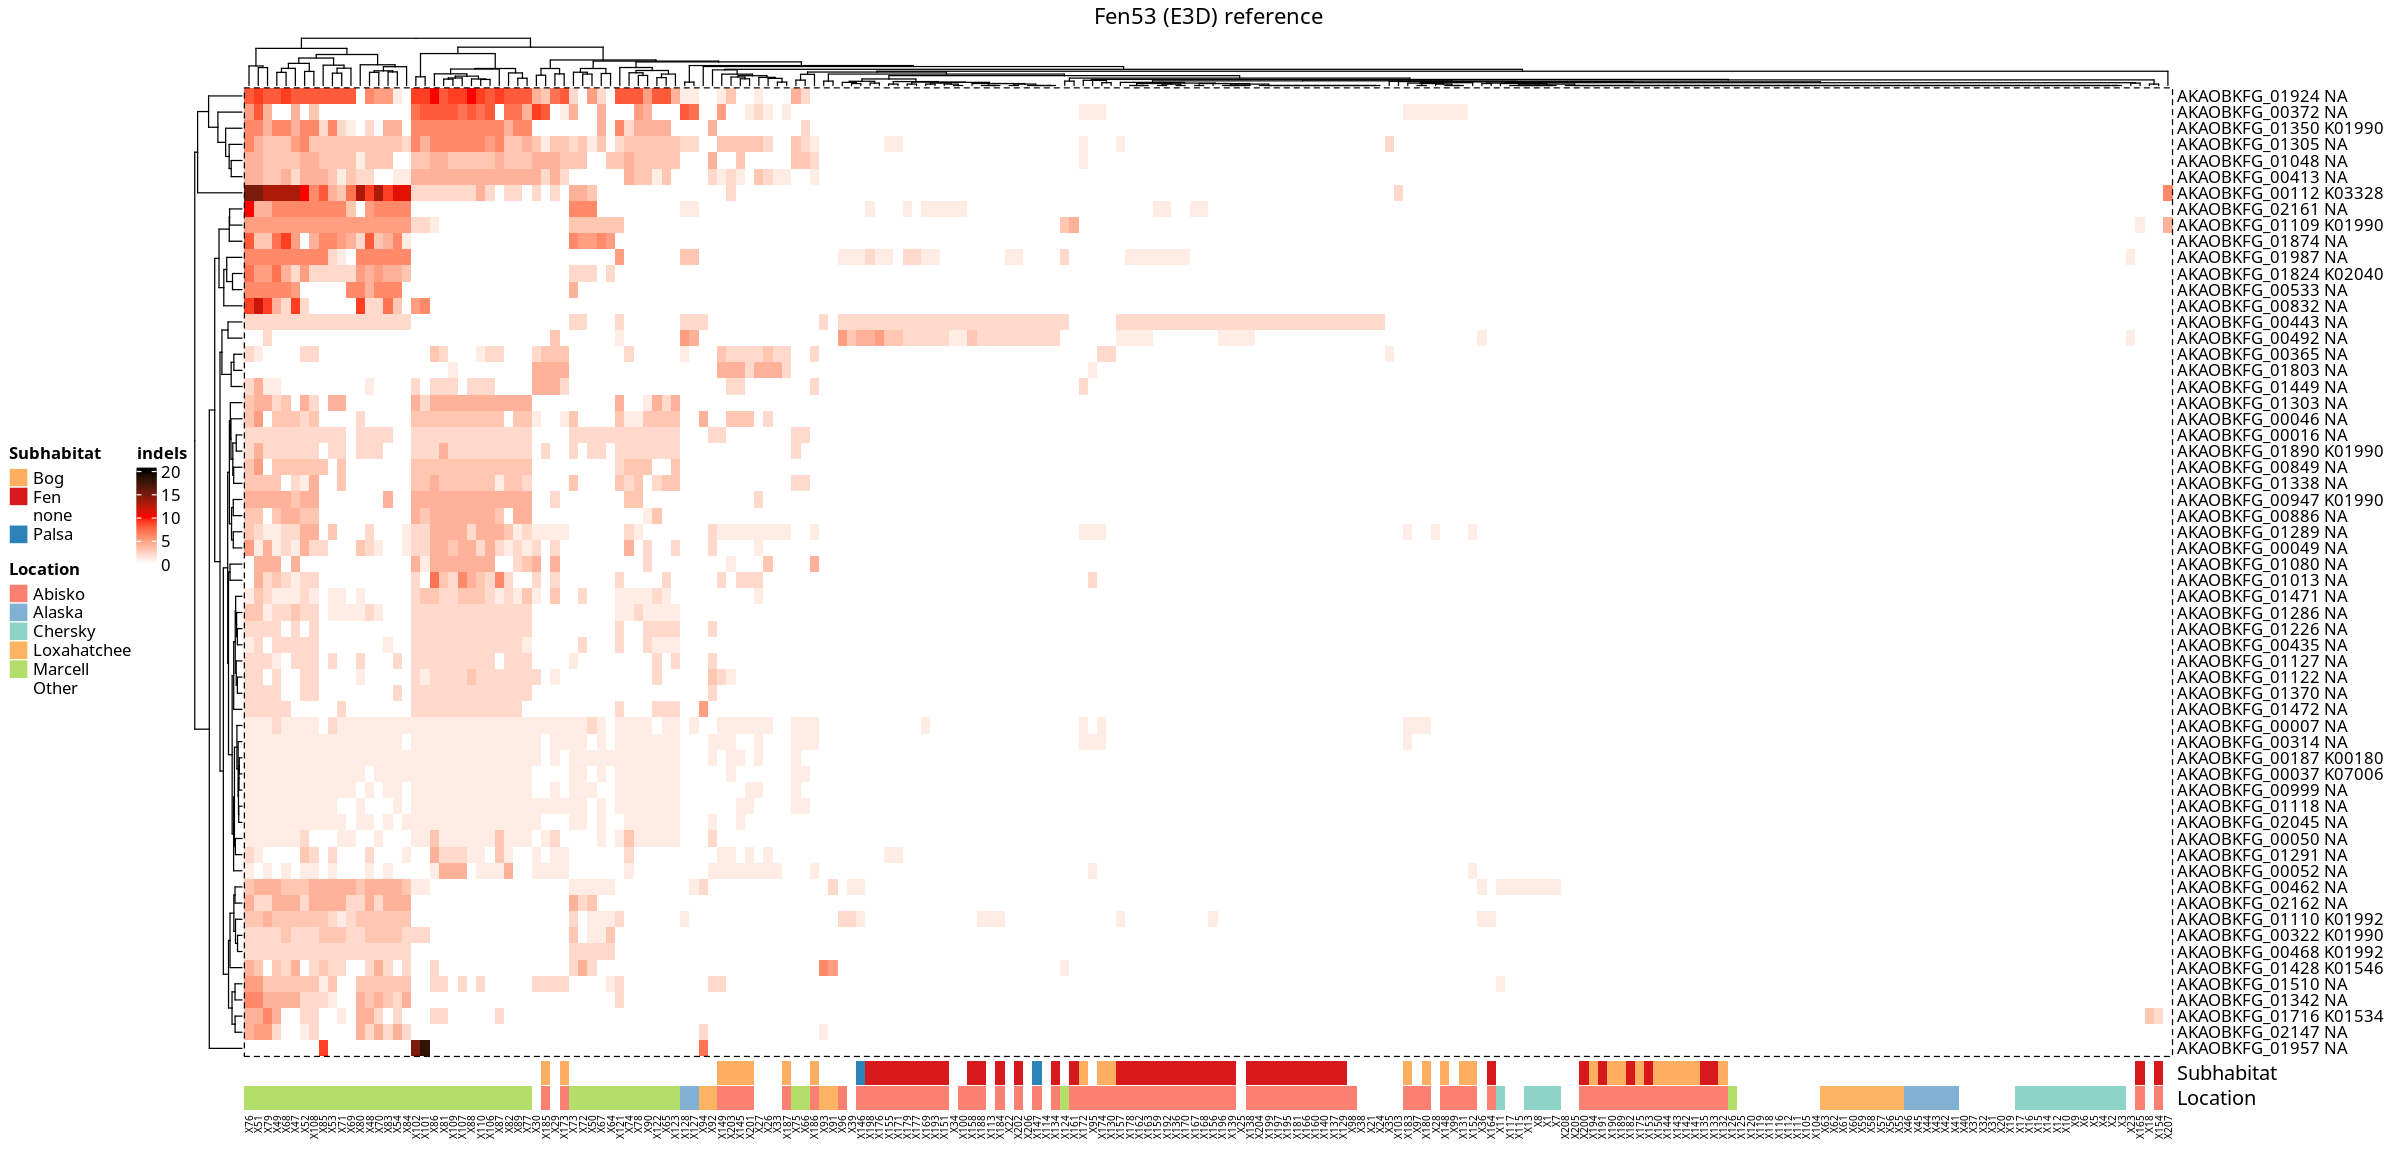

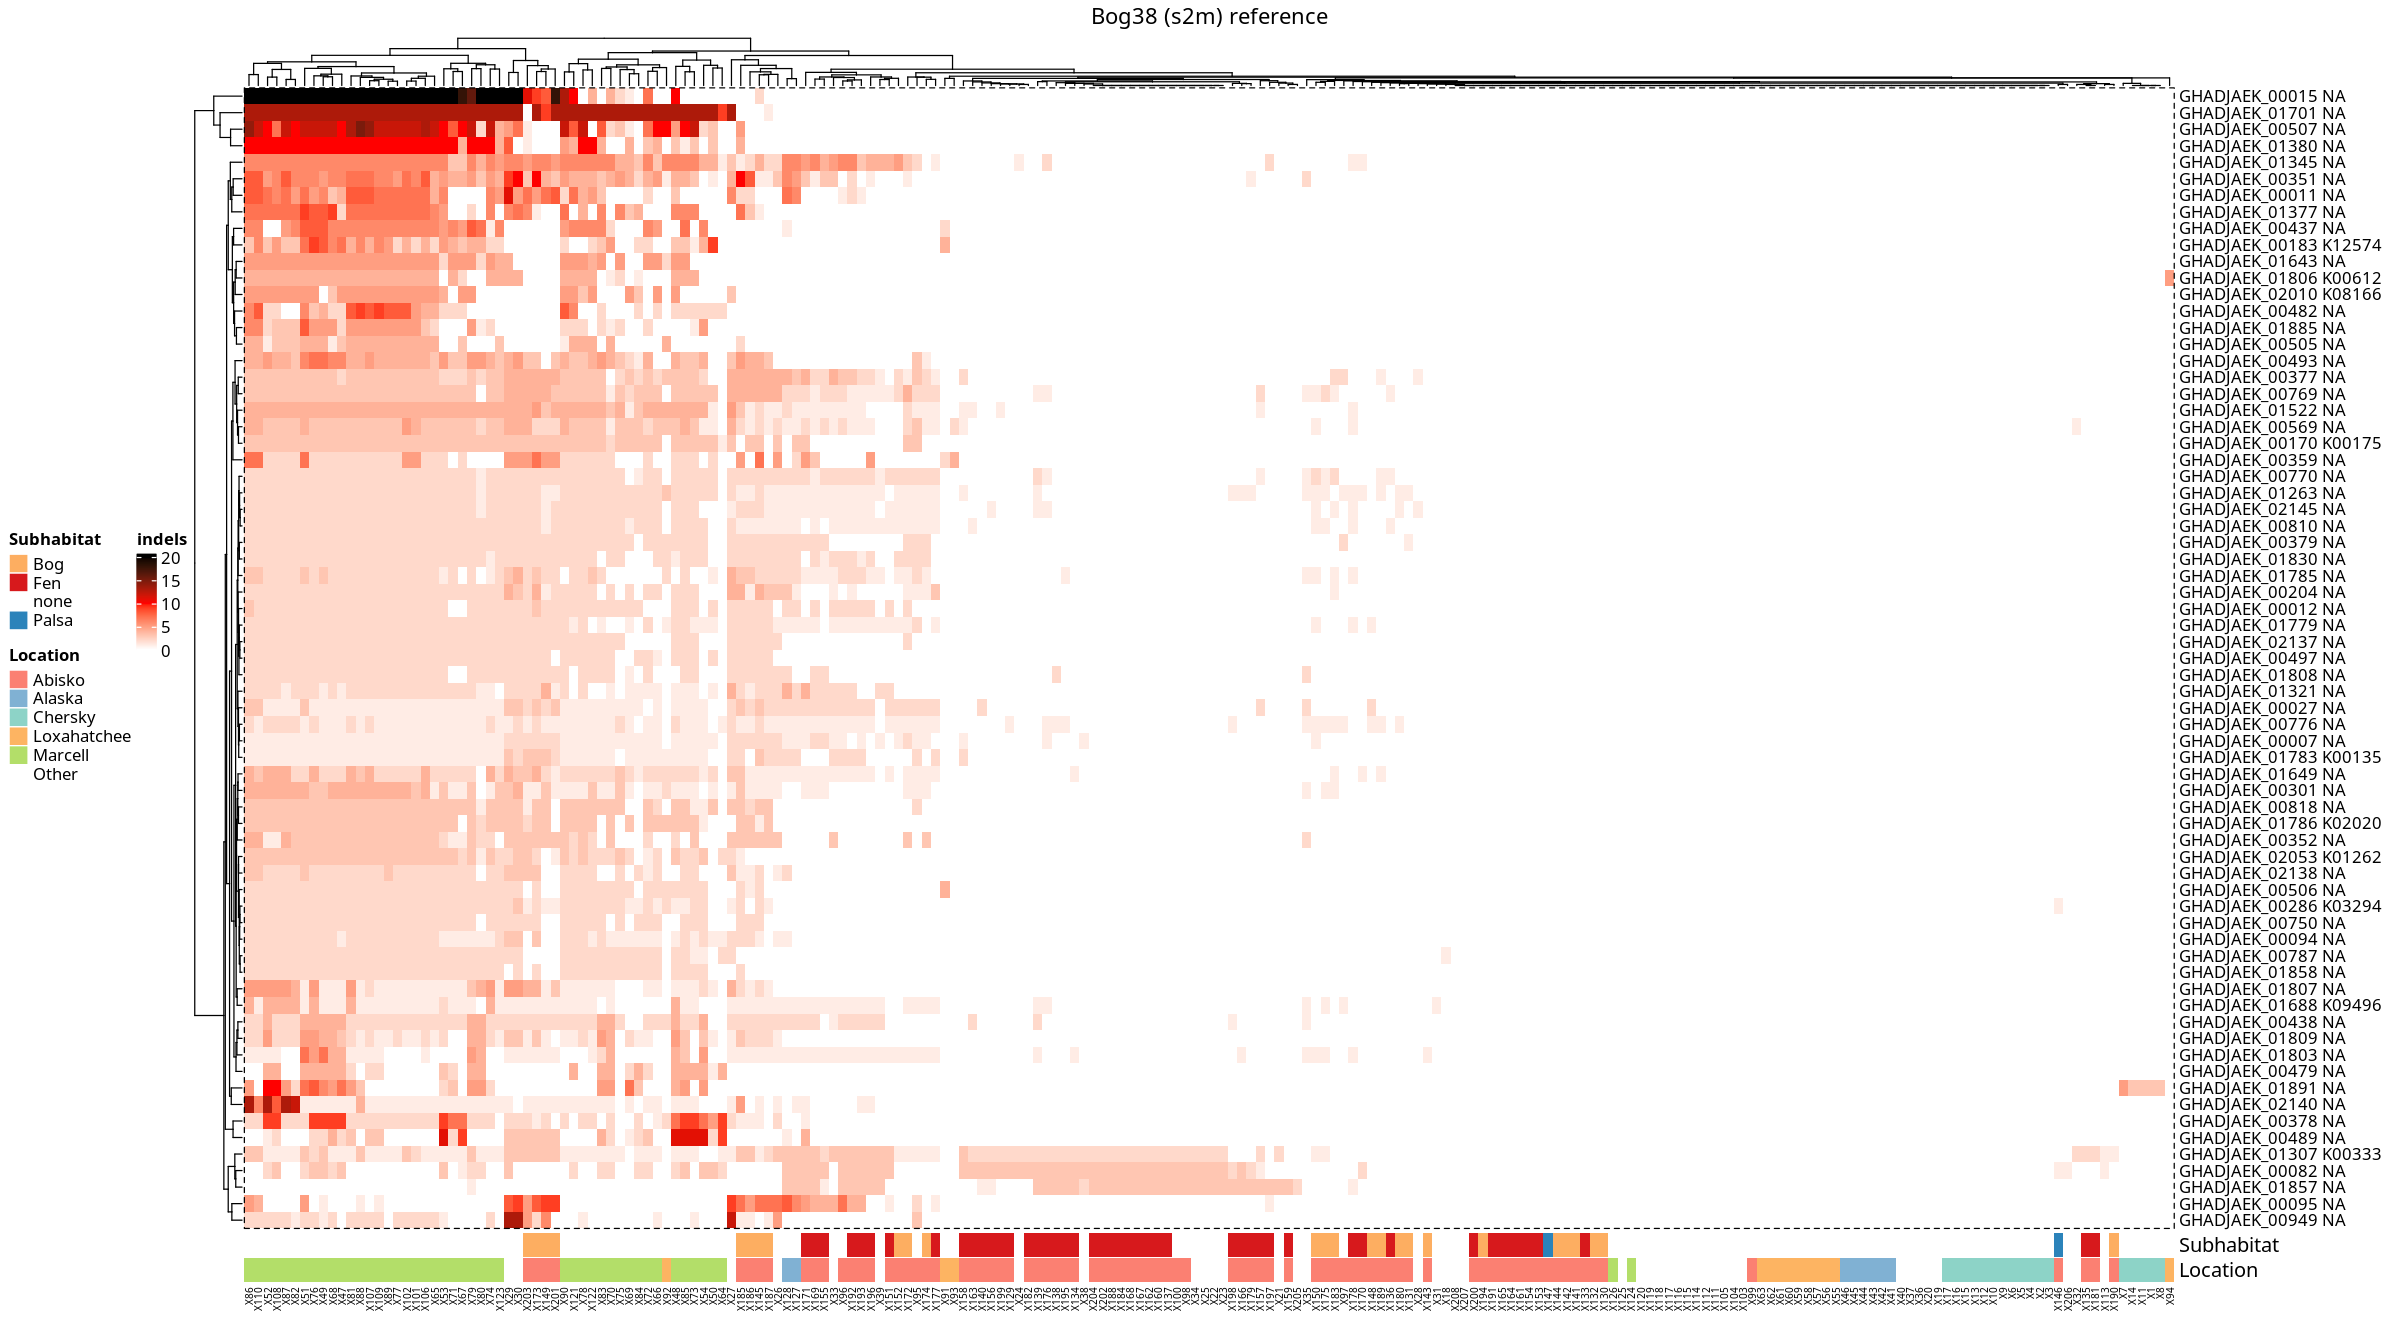

In [28]:
# trying to get KOs plotted -- should try with pfams

ko_e2d <- merge(e2d_indels_filt, subset(ko5, genome=="fen3"), by="locus_tag", all.x=TRUE) 
ko_e3d <- merge(e3d_indels_filt, subset(ko5, genome=="fen53"), by="locus_tag", all.x=TRUE) 
ko_s2m <- merge(s2m_indels_filt, subset(ko5, genome=="bog38"), by="locus_tag", all.x=TRUE) 


split_function2 <- function(indels, tsv){ 
#     colnames(indels) <- c(1:208,"locus_tag")
    indels3 <- merge(indels, tsv, by="locus_tag", all.x=TRUE)

    indels3$gene_loc <- paste(indels3$locus_tag, indels3$ko)
    indels4 <- indels3 %>% remove_rownames %>% column_to_rownames(var="gene_loc")
    indels5 <- indels4[,2:209]

    indels5$mean <- apply(indels5, 1, mean, na.rm=TRUE)
    indels5$min <- do.call(pmin, indels5)
    indels5$max <- do.call(pmax, indels5)

    
    return(indels5)
}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

e2d_matrix <- split_function2(ko_e2d, e2d_tsv)
e2d_low <- subset(e2d_matrix, mean>upper_boundary_e2d)

h <- 0.16*nrow(e2d_low)
options(repr.plot.width=20, repr.plot.height=h)
hma <- heatmap_function(e2d_low[,1:208], col_fun,"Fen3 (E2D) reference")
draw(hma, heatmap_legend_side = "left", annotation_legend_side = "left")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
e3d_matrix <- split_function2(ko_e3d, e3d_tsv)
e3d_low <- subset(e3d_matrix, mean>upper_boundary_e3d)

h <- 0.16*nrow(e3d_low)
options(repr.plot.width=20, repr.plot.height=h)
hma <- heatmap_function(e3d_low[,1:208], col_fun,"Fen53 (E3D) reference")
draw(hma, heatmap_legend_side = "left", annotation_legend_side = "left")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
s2m_matrix <- split_function2(ko_s2m, s2m_tsv)
s2m_low <- subset(s2m_matrix, mean>upper_boundary_s2m)

h <- 0.16*nrow(s2m_low)
options(repr.plot.width=20, repr.plot.height=h)
hma <- heatmap_function(s2m_low[,1:208], col_fun,"Bog38 (s2m) reference")
draw(hma, heatmap_legend_side = "left", annotation_legend_side = "left")


Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“Heatmap/annotation names are duplicated: Indels”
Warning message:
“Heatmap/annotation names are duplicated: Indels, Indels”


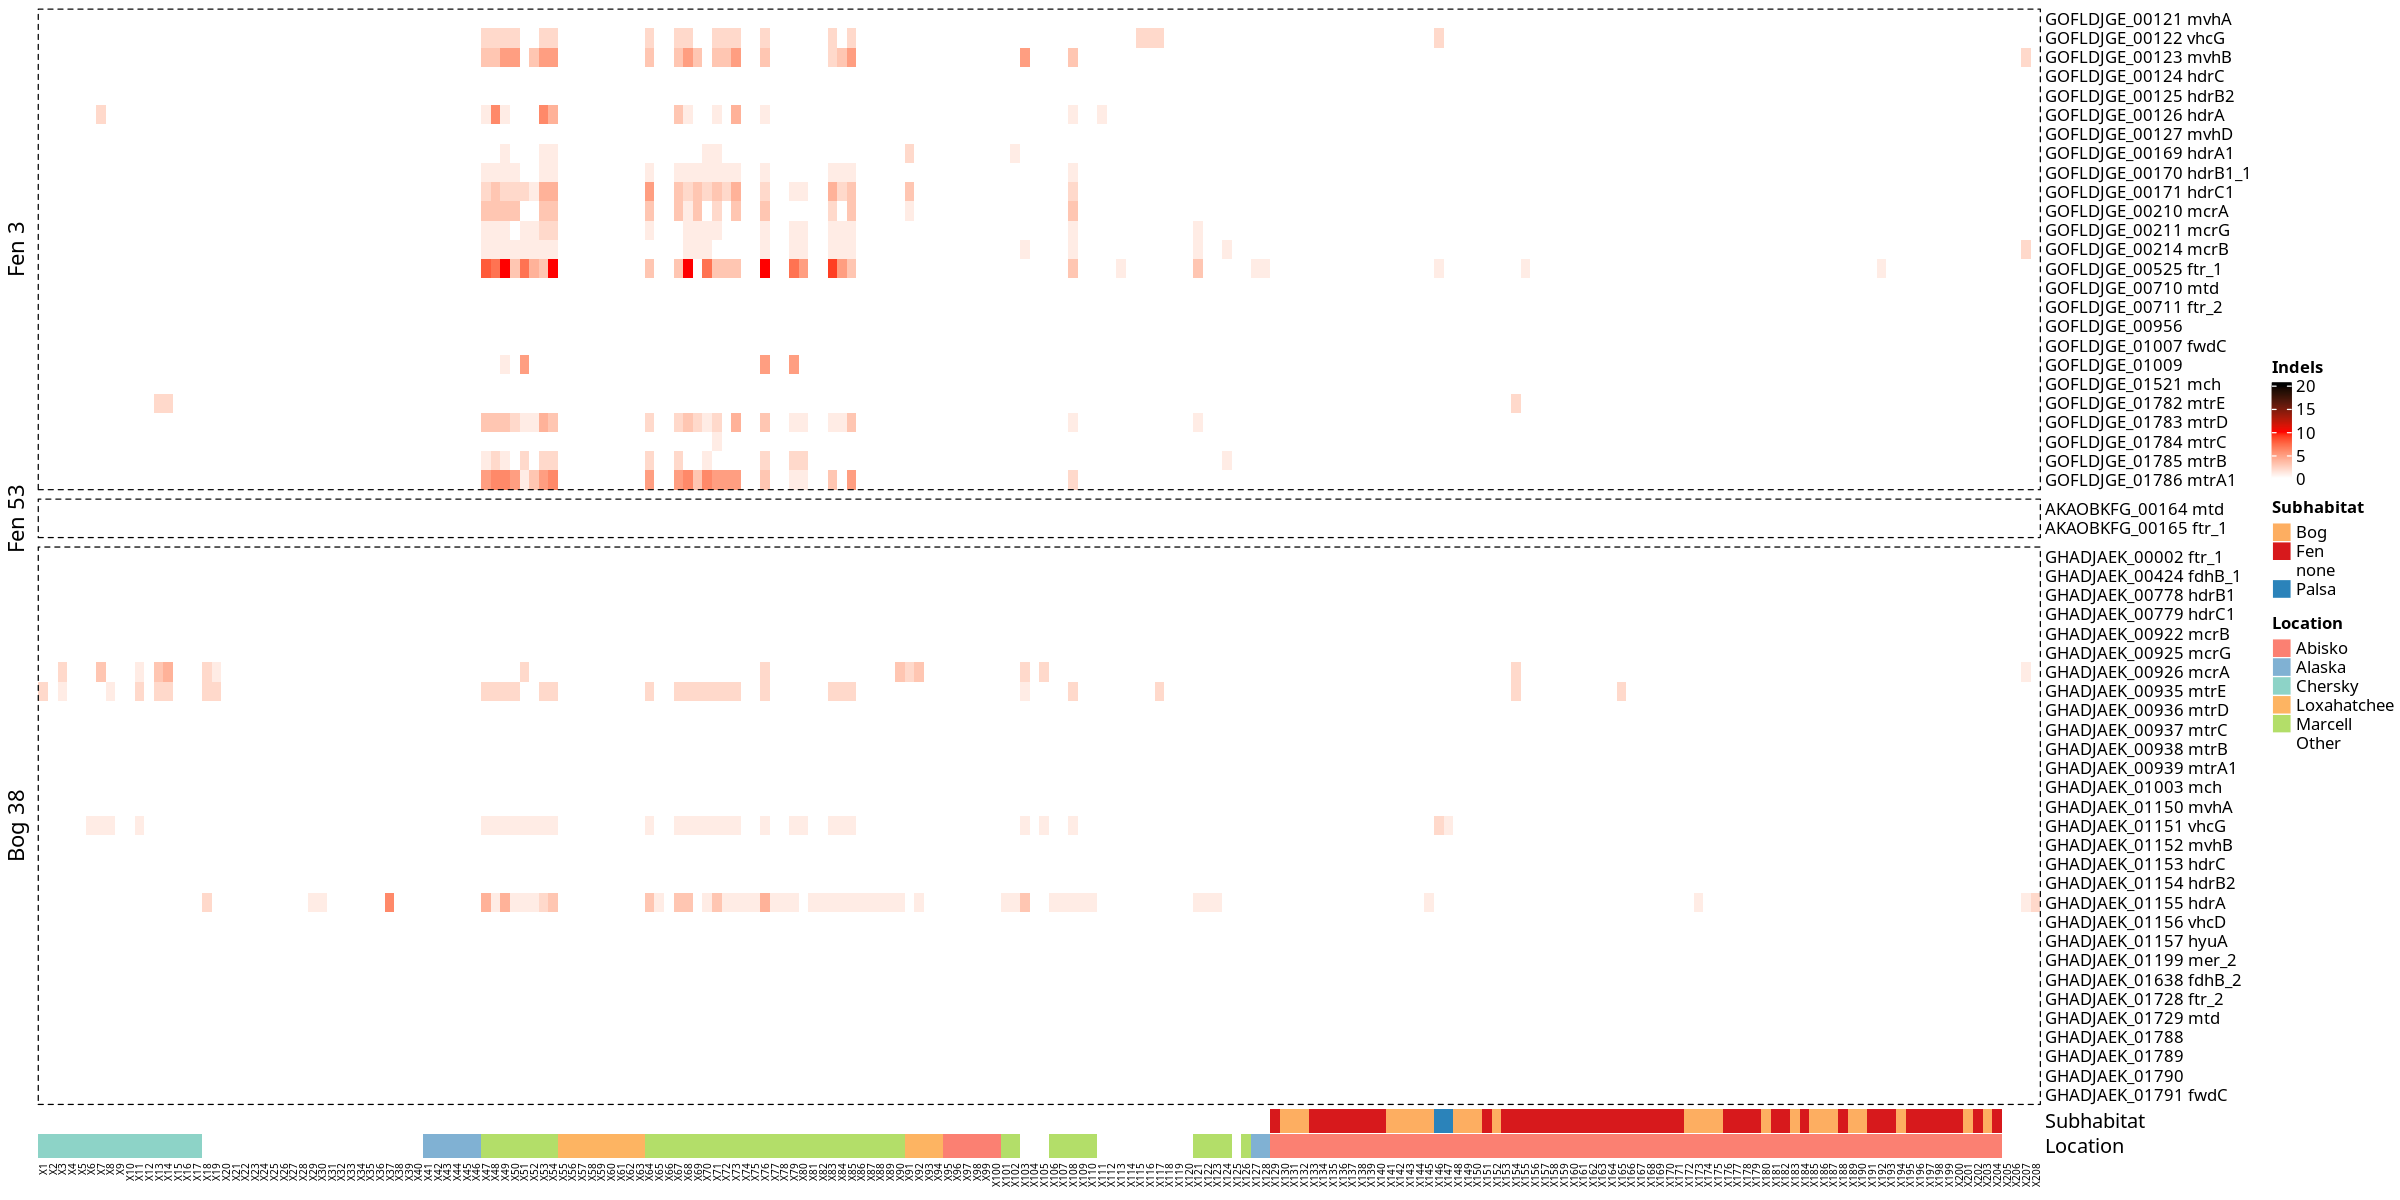

In [29]:
# all of the hydrogenotrophic genes from kegg 

meth_genes_kegg <- fread('/work/microbiome/abisko/eilish/09_methanoflorens/hydrogenotrophic_methanogenesis_kegg.txt')

split_function5 <- function(dnds, tsv){ 
#     colnames(dnds) <- c(1:208,"locus_tag")
    dnds3 <- merge(dnds, tsv, by="locus_tag", all.x=TRUE)
    return(dnds3)
}

t1 <- split_function5(ko_e2d, e2d_tsv)
t2 <- split_function5(ko_e3d, e3d_tsv)
t3 <- split_function5(ko_s2m, s2m_tsv)

ripper_function <- function(df, filter_by){
    #filter
    df2 <- subset(df, ko %in% filter_by)
    #rownames 
    df2$gene_loc <- paste(df2$locus_tag, df2$gene)
    df3 <- df2 %>% remove_rownames %>% column_to_rownames(var="gene_loc")
    #remove columns
    df4 <- df3[,2:209]
    return(df4)
}

o1 <- ripper_function(t1, meth_genes_kegg$ko)
o2 <- ripper_function(t2, meth_genes_kegg$ko)
o3 <- ripper_function(t3, meth_genes_kegg$ko)


hma1 <- heatmap_function2(o1, col_fun, "Fen 3")
hma2 <- heatmap_function2(o2, col_fun,"Fen 53")
hma3 <- heatmap_function3(o3, col_fun, "Bog 38")

options(repr.plot.width=20, repr.plot.height=10)

sexy_list <- hma1%v%hma2%v%hma3

draw(sexy_list)

In [30]:

split_function3 <- function(indels, tsv){ 
    indels3 <- merge(indels, tsv, by="locus_tag", all.x=FALSE)
    indels3$mean <- apply(indels3[,2:209], 1, mean, na.rm=TRUE)

    return(indels3)
}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

e2d_matrix <- split_function3(ko_e2d, e2d_tsv)
e2d_low <- subset(e2d_matrix, mean>upper_boundary_e2d)
e2d_subset <-  e2d_low[complete.cases(e2d_low), ] 

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
e3d_matrix <- split_function3(ko_e3d, e3d_tsv)
e3d_low <- subset(e3d_matrix, mean>upper_boundary_e3d)
e3d_subset <-  e3d_low[complete.cases(e3d_low), ] 


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
s2m_matrix <- split_function3(ko_s2m, s2m_tsv)
s2m_low <- subset(s2m_matrix, mean>upper_boundary_s2m)
s2m_subset <-  s2m_low[complete.cases(s2m_low), ] 

test <- merge(e2d_subset[,c(1,210,212,215)], e3d_subset[,c(1,210,212,215)], by=c("ko","gene", "genome", "locus_tag"),
              all=TRUE)
test2 <- merge(test, s2m_subset[,c(1,210,212,215)], by=c("ko","gene", "genome", "locus_tag"), all=TRUE) #must modify
head(test2)

write.table(test2, "ko_test.tsv", sep='\t')

ko     gene   genome locus_tag     
1 K00135        bog38  GHADJAEK_01783
2 K00158 iolD_3 fen3   GOFLDJGE_00569
3 K00175        bog38  GHADJAEK_00170
4 K00180 iorB   fen53  AKAOBKFG_00187
5 K00205 mvhB   fen3   GOFLDJGE_00123
6 K00333 mbhL   bog38  GHADJAEK_01307

In [31]:
unique(ko5$genome)

[1] "fen53" "bog38" "fen3"  "e3d"   "e2d"   "s2m"

In [32]:
pfame2d <- fread(header=FALSE, 
              fill=TRUE, 
              "grep -v '^#' /work/microbiome/abisko/eilish/09_methanoflorens/pfam_e2d.csv")

pfame3d <- fread(header=FALSE, 
              fill=TRUE, 
              "grep -v '^#' /work/microbiome/abisko/eilish/09_methanoflorens/pfam_e3d.csv")

pfams2m <- fread(header=FALSE, 
              fill=TRUE, 
              "grep -v '^#' /work/microbiome/abisko/eilish/09_methanoflorens/pfam_s2m.csv")
# pfam$description  <- paste(pfam$V23,pfam$V24,pfam$V25,pfam$V26,pfam$V27,pfam$V28)
# pfam <- pfam[,c(1:22, 29)]

pfam_headers <- c('locus_tag',
                    'accession',
                    'tlen',
                    'query_name',
                    'accession2',
                    'qlen',
                    'E-value',
                    'score',
                    'bias',
                    'number',
                    'of',
                    'c-Evalue',
                    'i-Evalue',
                    'score',
                    'bias',
                    'hmm_from',
                    'hmm_to',
                    'ali_from',
                    'ali_to',
                    'env_from',
                    'env_to',
                    'acc',
                    'description')

pfunct <- function(pfam, filt){
    colnames(pfam) <- pfam_headers
    pfam$comb <- paste(pfam$locus_tag, pfam$accession2, pfam$description)
    pfam2 <- pfam[,c(1,23,24)]
    pfam3 <- merge(pfam2, filt, by="locus_tag", all=FALSE) 
    pfam3$mean <- apply(pfam3[,4:211], 1, mean, na.rm=TRUE)
    pfam_low <- distinct(subset(pfam3, mean>0.3))[,3:211]
    pfam_low2 <- pfam_low %>% remove_rownames %>% column_to_rownames(var="comb")
    return(pfam_low2)
#     
}



Warning message:
“The input is a data frame, convert it to a matrix.”
Warning message:
“The input is a data frame, convert it to a matrix.”


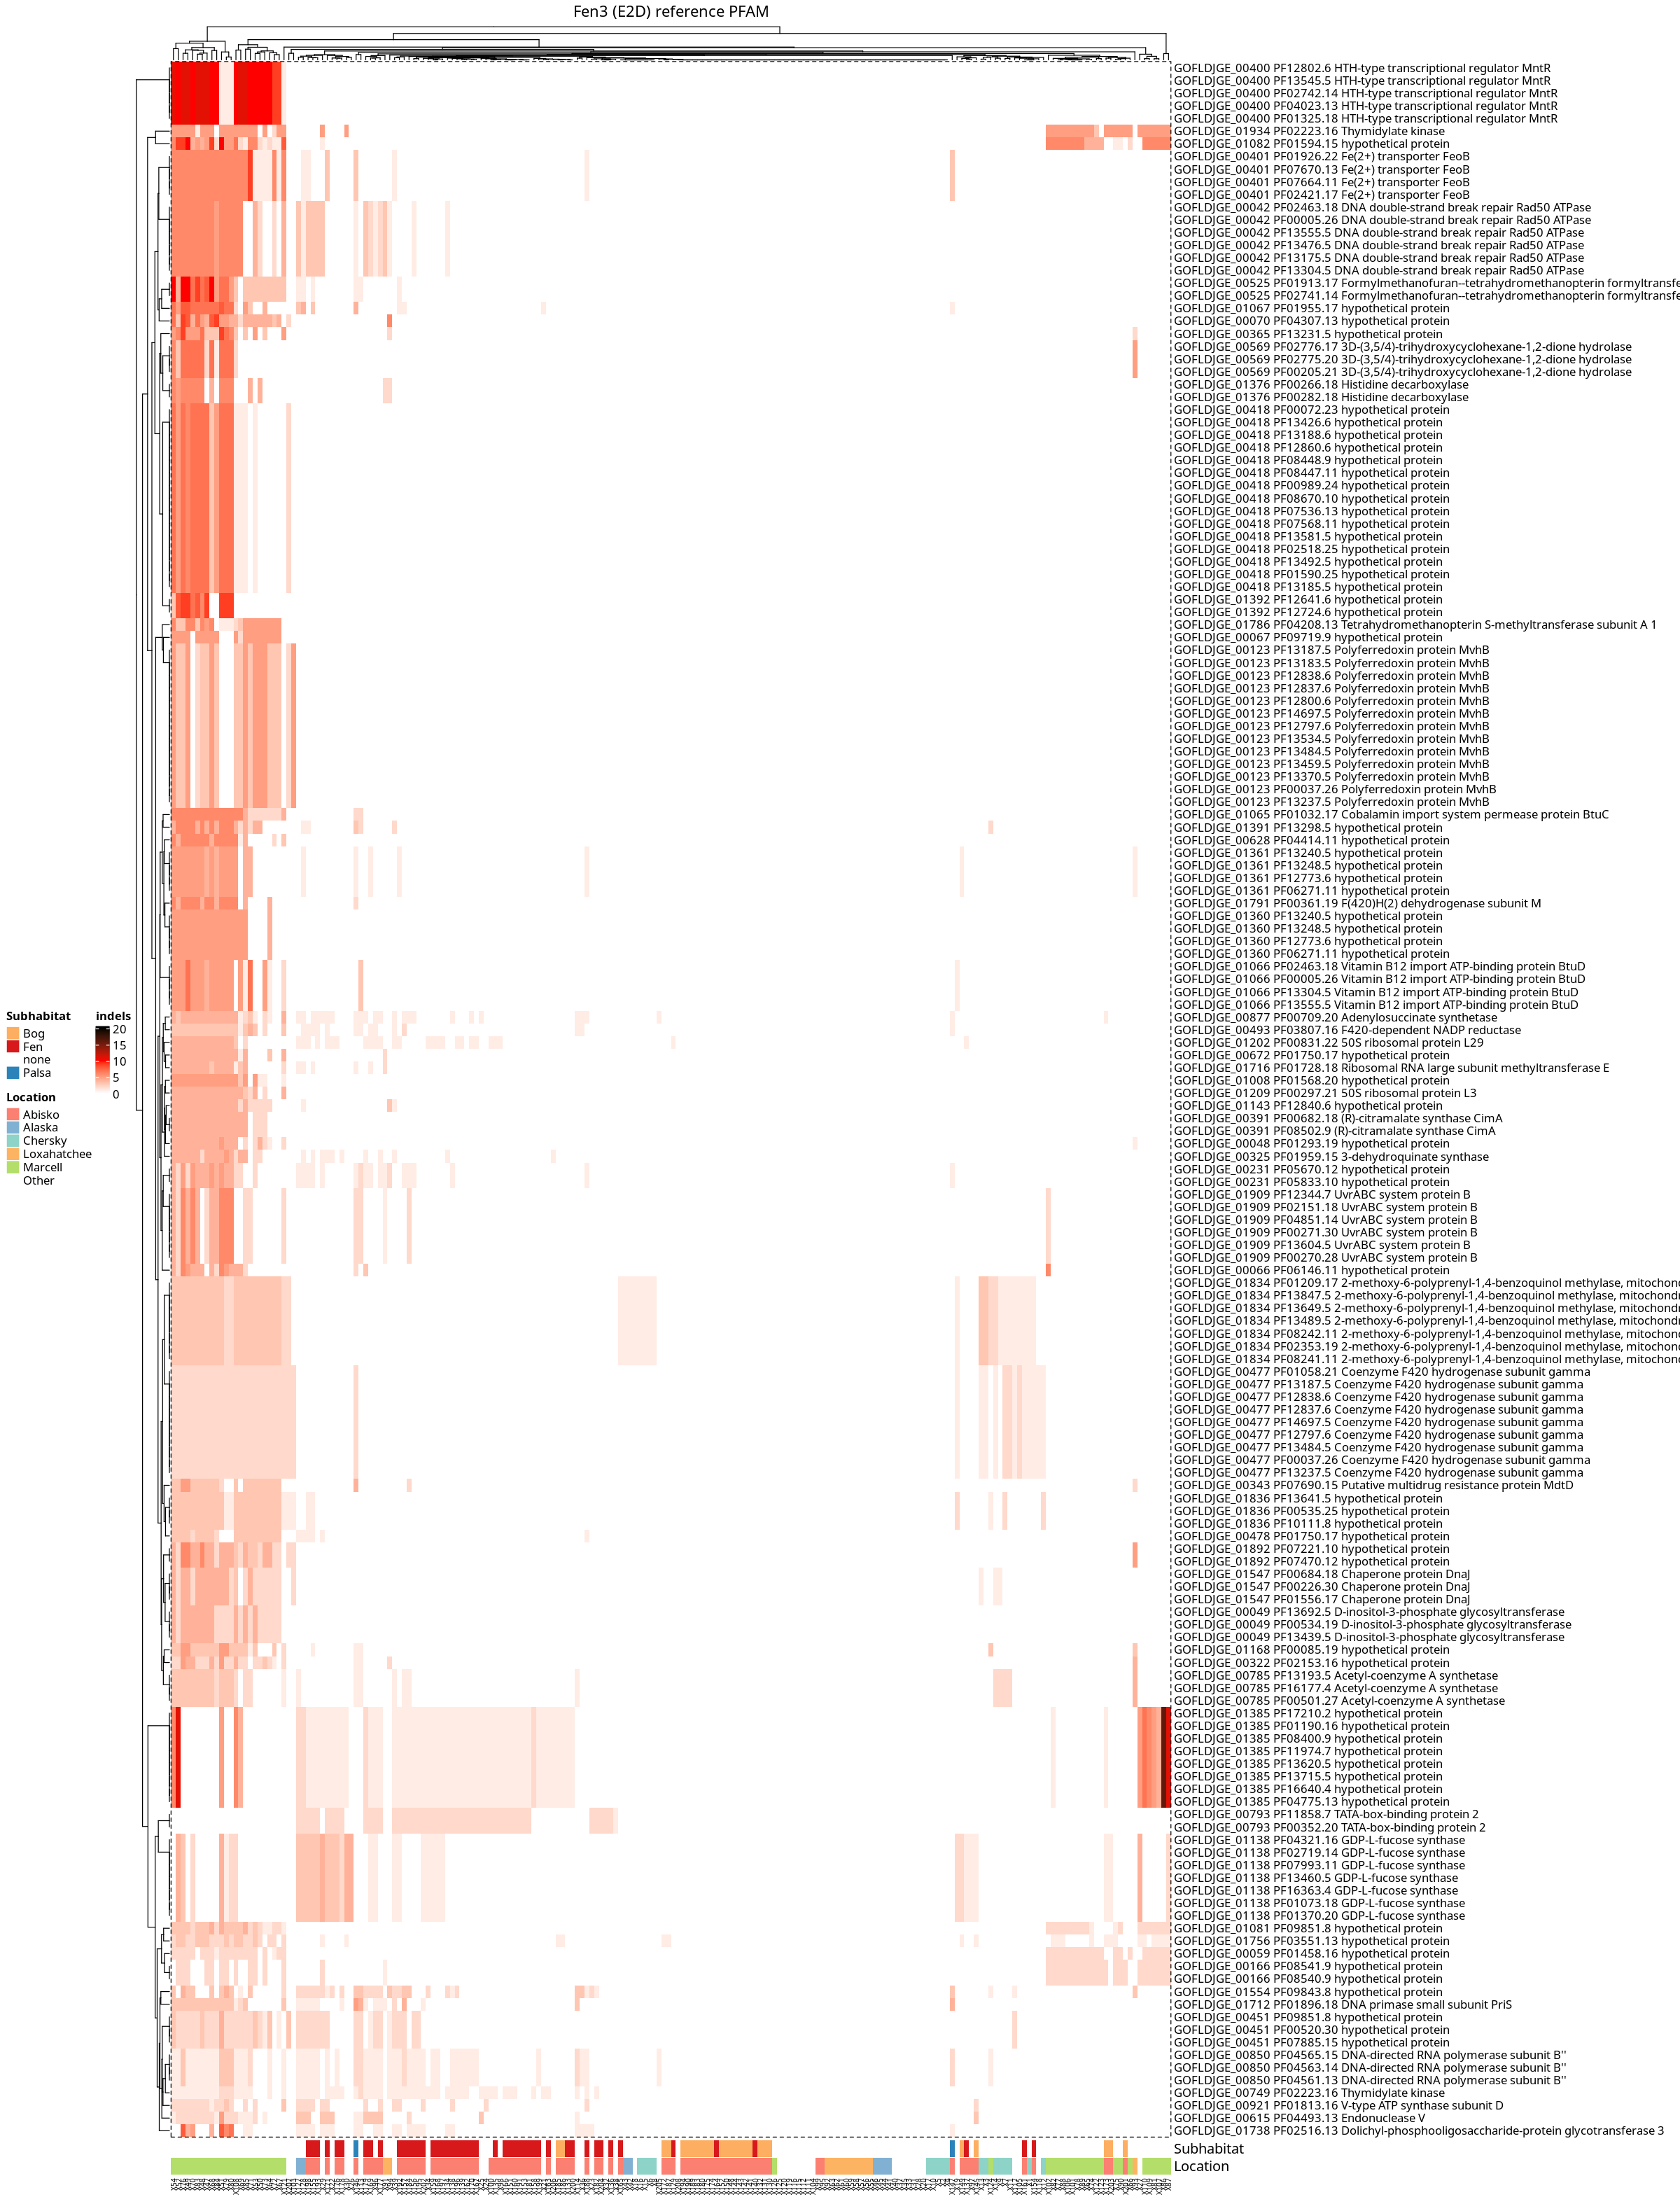

Warning message:
“The input is a data frame, convert it to a matrix.”


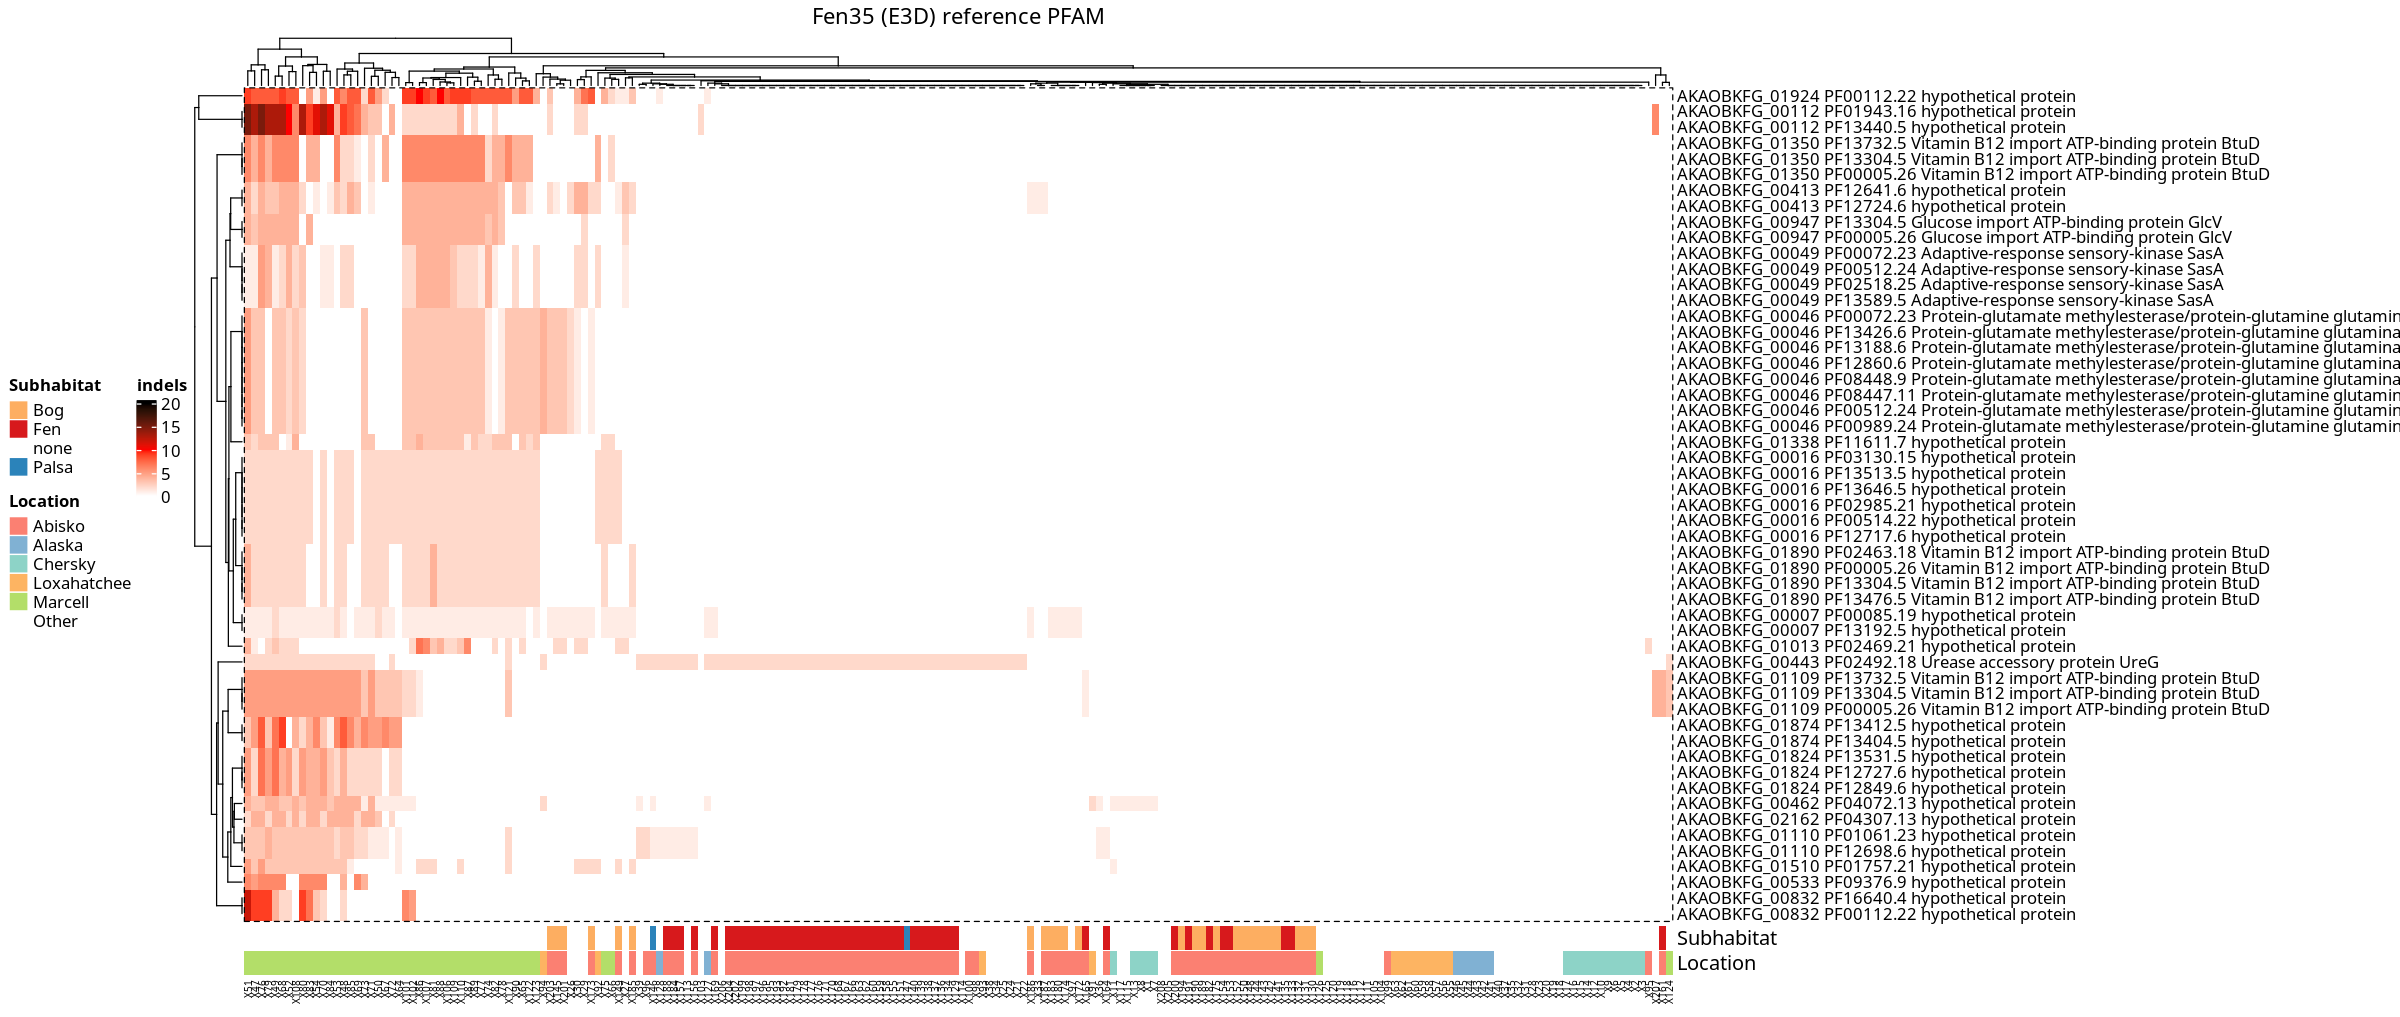

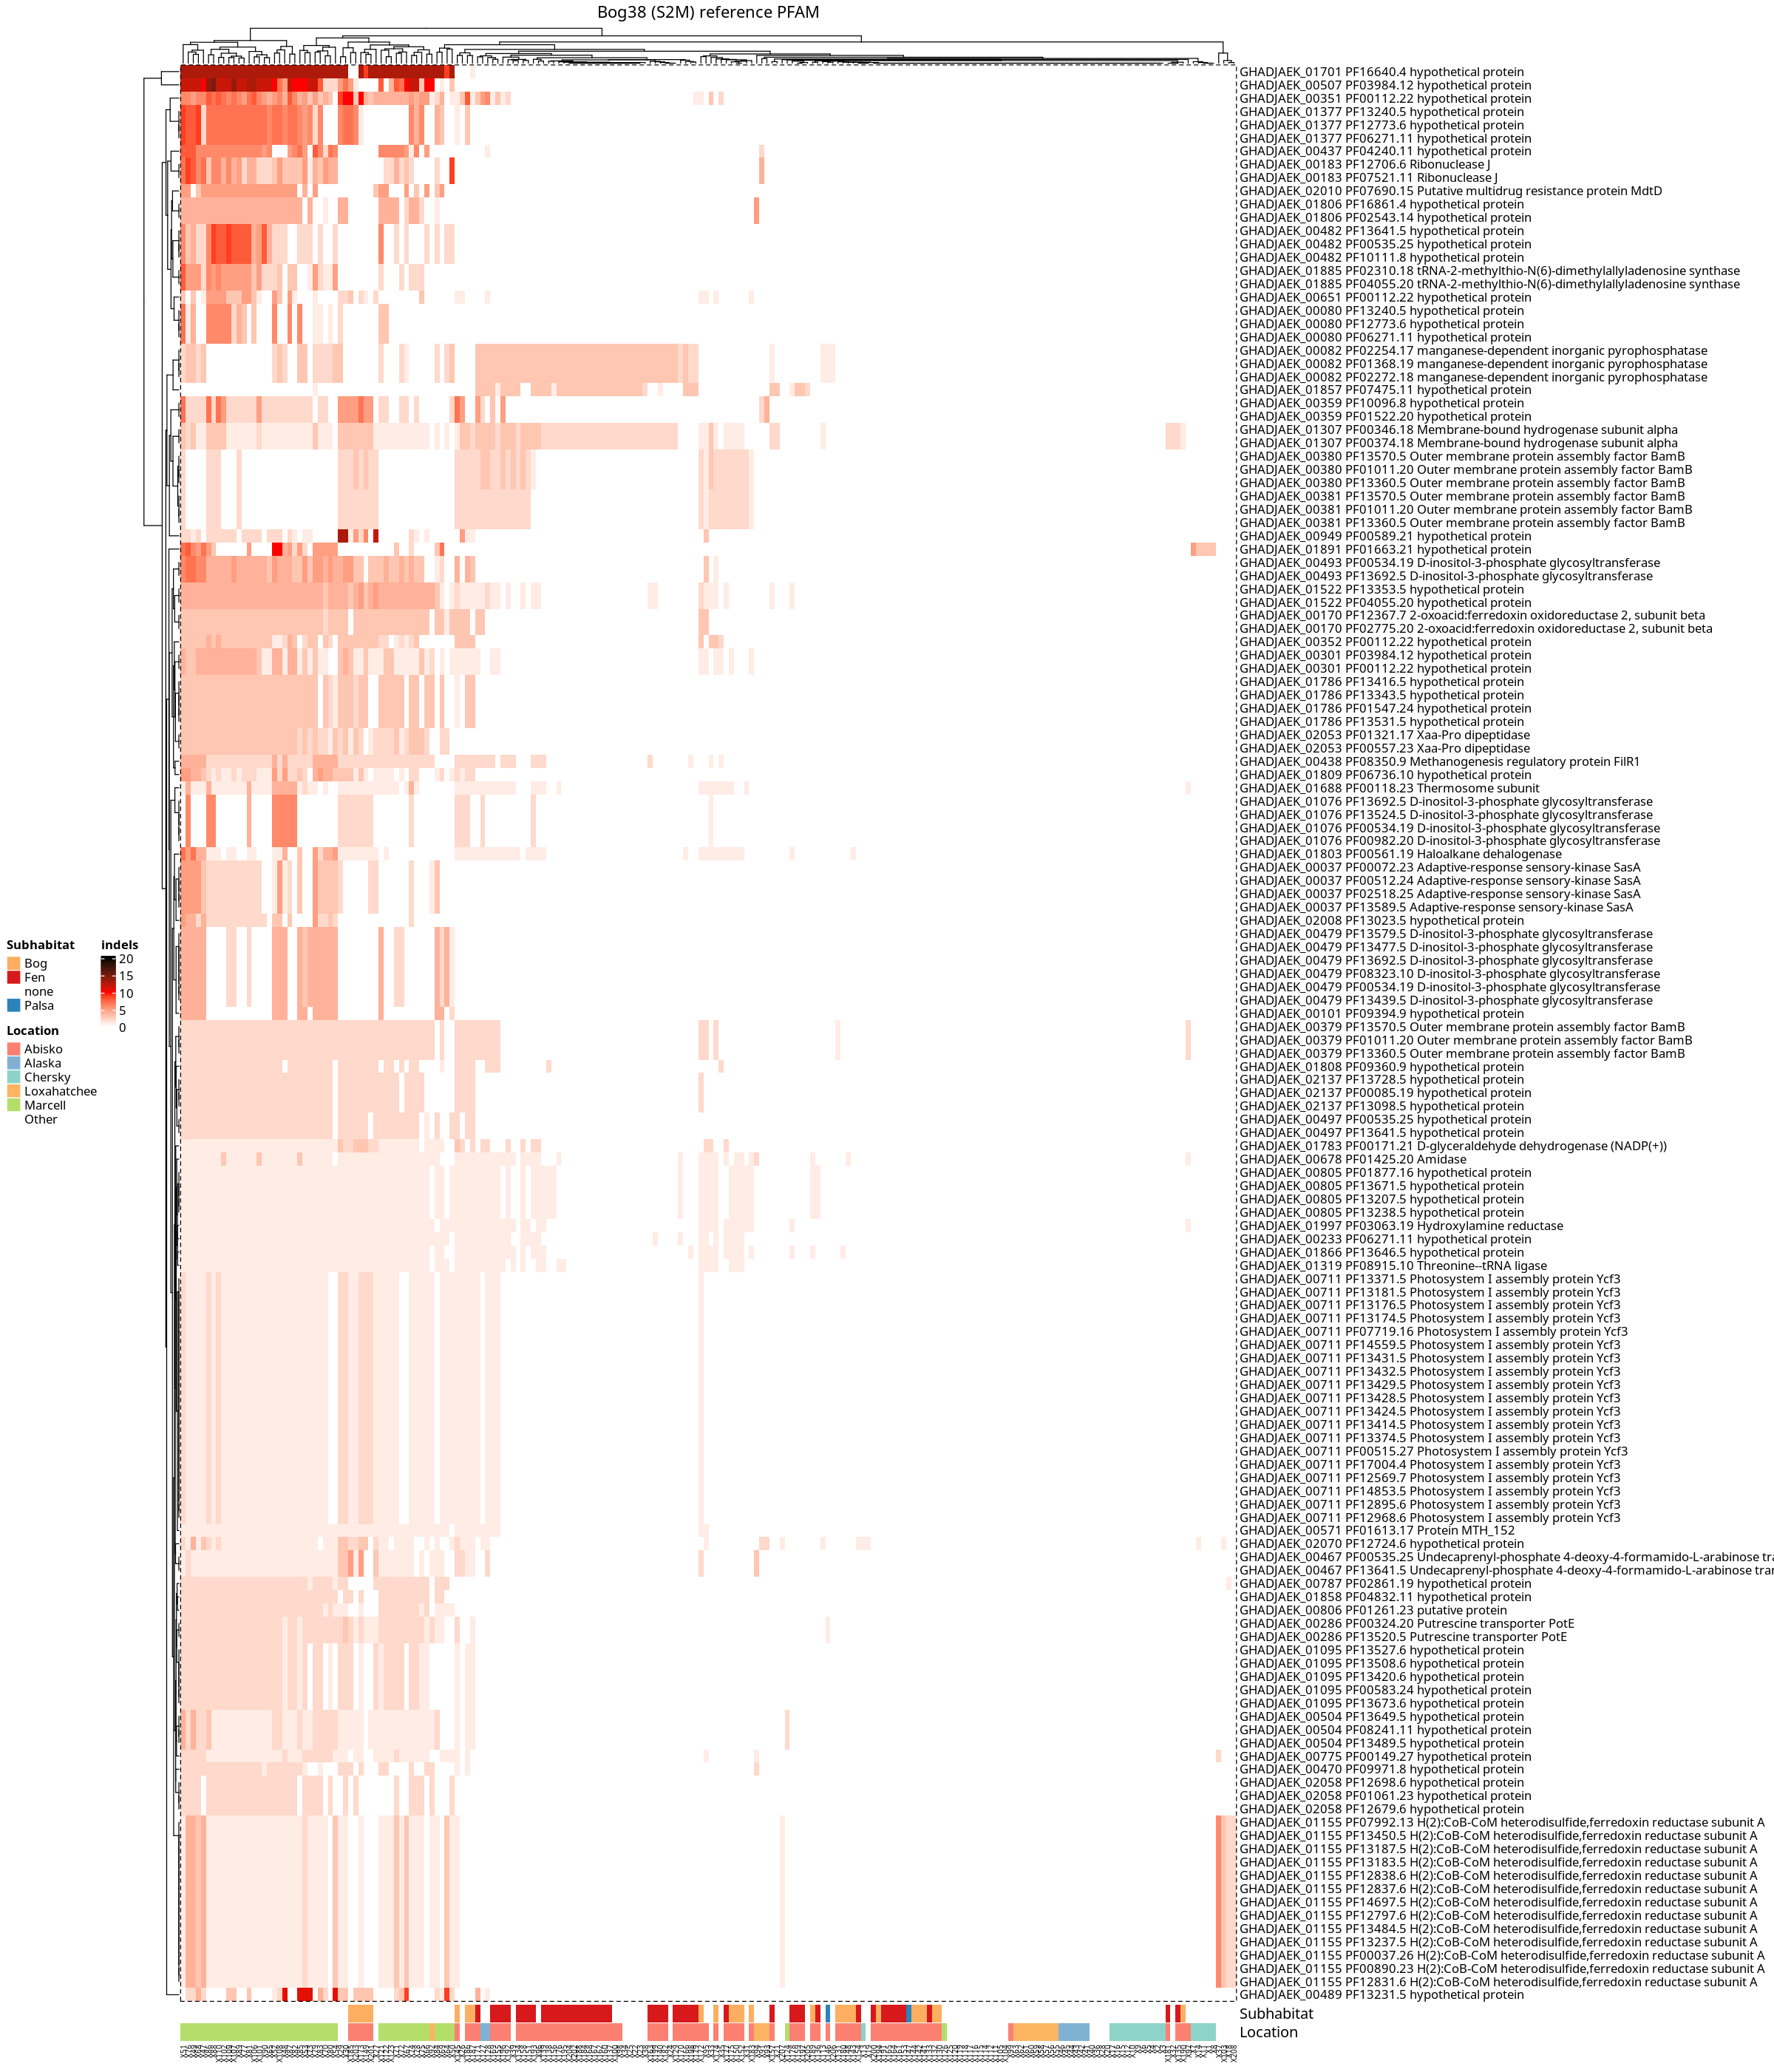

In [33]:
# average >1 pfam
e2d_pfam <- pfunct(pfame2d, e2d_indels_filt)
e3d_pfam <- pfunct(pfame3d, e3d_indels_filt)
s2m_pfam <- pfunct(pfams2m, s2m_indels_filt)

h <- 0.16*nrow(e2d_pfam)
options(repr.plot.width=20, repr.plot.height=h)
hma <- heatmap_function(e2d_pfam, col_fun,"Fen3 (E2D) reference PFAM")
draw(hma, heatmap_legend_side = "left", annotation_legend_side = "left")

h <- 0.16*nrow(e3d_pfam)
options(repr.plot.width=20, repr.plot.height=h)
hma <- heatmap_function(e3d_pfam, col_fun,"Fen35 (E3D) reference PFAM")
draw(hma, heatmap_legend_side = "left", annotation_legend_side = "left")

h <- 0.16*nrow(s2m_pfam)
options(repr.plot.width=20, repr.plot.height=h)
hma <- heatmap_function(s2m_pfam, col_fun,"Bog38 (S2M) reference PFAM")
draw(hma, heatmap_legend_side = "left", annotation_legend_side = "left")




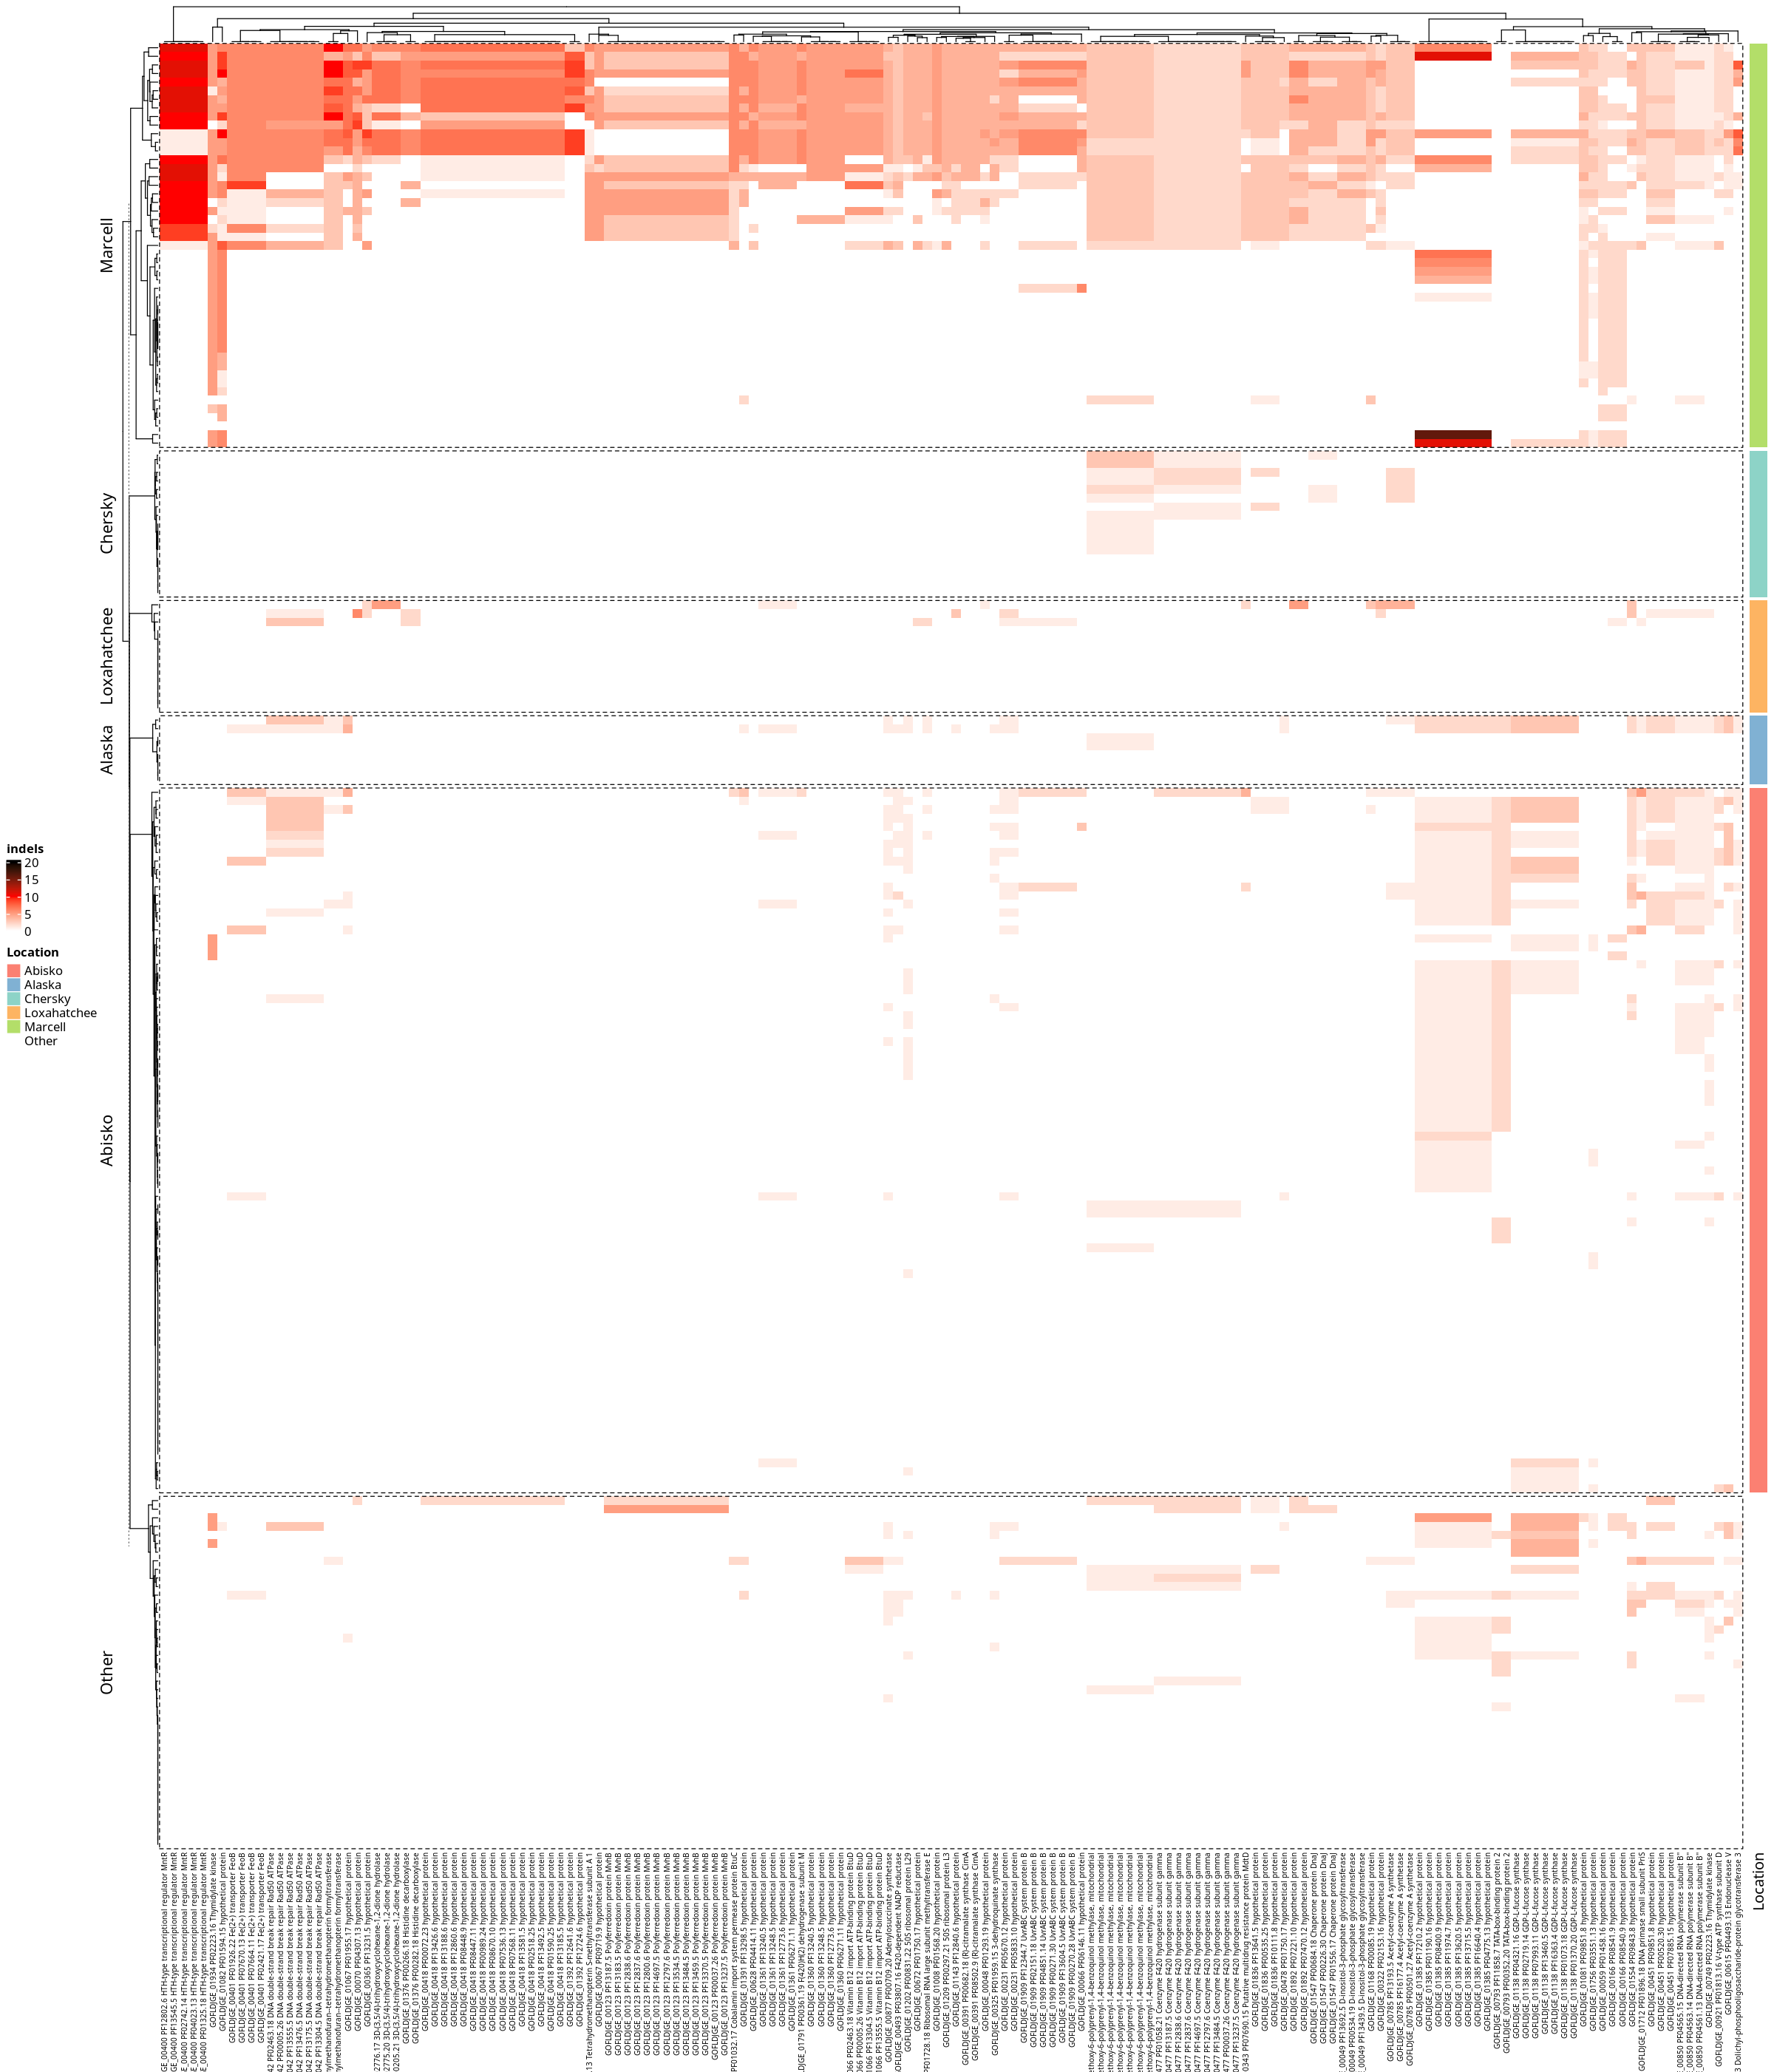

In [34]:
location2 = rowAnnotation(Location = metadata$location,
    col = list(Location = c('Chersky'='#8DD3C7',
                       'Other'='white',
                       'Alaska'='#80B1D3',
                       'Marcell'='#B3DE69',
                       'Loxahatchee'='#FDB462',
                       'Abisko'='#FB8072')))

test <- Heatmap(t(e2d_pfam), col=col_fun,
                    name = "indels", #title of legend
                    row_names_gp = gpar(fontsize = 10),
                    column_names_gp = gpar(fontsize = 6),
                    row_names_max_width = unit(15, "cm"),
                    border_gp = gpar(col = "black", lty = 2),
                    split=metadata$location
       )

draw(test+location2, heatmap_legend_side = "left", annotation_legend_side = "left")



# ha2 = rowAnnotation(foo=foo,
#                 #cn=anno_text(cn, rot=0, just="right", which="row"),
#                 annotation_height=unit.c(unit(5, "mm"), max_text_width(cn)))

# draw(Heatmap(t(mat), split=foo, show_row_names=TRUE) + ha2, heatmap_legend_side="left", annotation_legend_side="left")

Warning message:
“The input is a data frame, convert it to a matrix.”


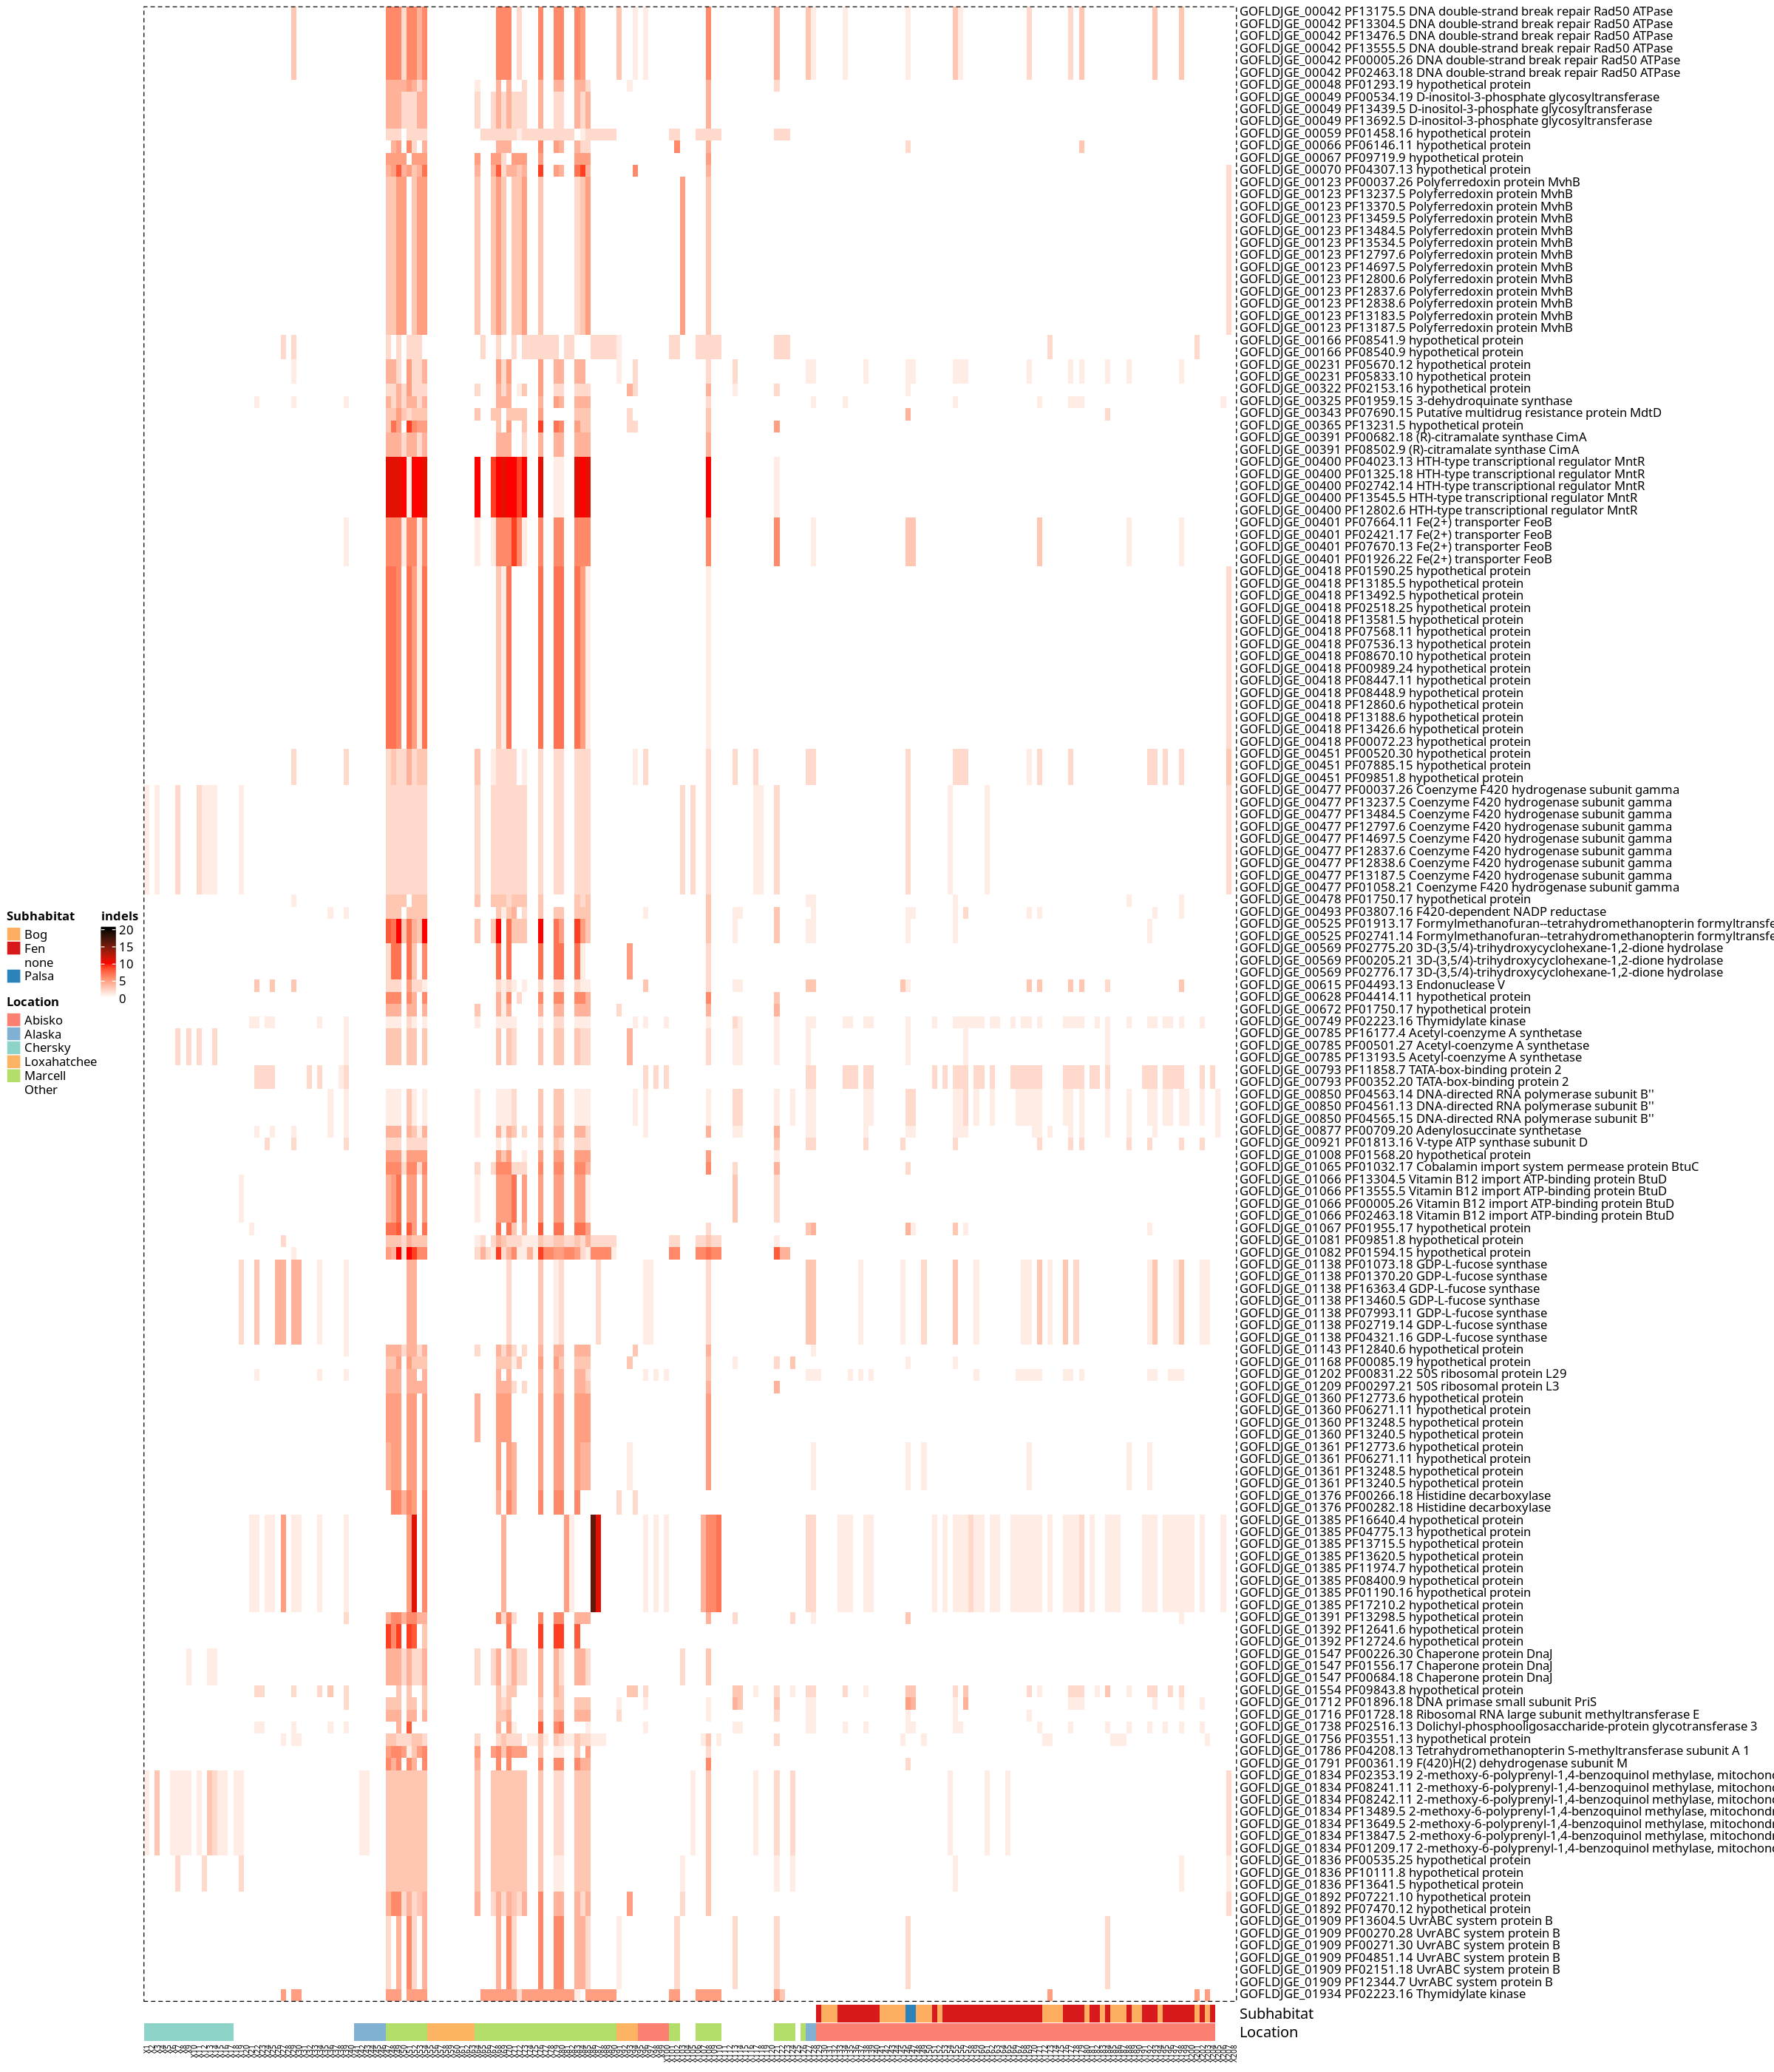

In [35]:
location2 = HeatmapAnnotation(Location = metadata$location,
    col = list(Location = c('Chersky'='#8DD3C7',
                       'Other'='white',
                       'Alaska'='#80B1D3',
                       'Marcell'='#B3DE69',
                       'Loxahatchee'='#FDB462',
                       'Abisko'='#FB8072')))


    plot <- Heatmap(e2d_pfam, col=col_fun,
                    name = "indels", #title of legend
                    row_names_gp = gpar(fontsize = 10),
                    column_names_gp = gpar(fontsize = 6),
                    bottom_annotation = c(subhab,location),
                    row_names_max_width = unit(15, "cm"),
                    border_gp = gpar(col = "black", lty = 2),
                    cluster_rows = FALSE,
                    cluster_columns = FALSE
               )

draw(plot, heatmap_legend_side = "left", annotation_legend_side = "left")


In [36]:
#making a common ko subset

common_ko <- intersect(s2m_matrix$ko, e2d_matrix$ko)
common_ko <- intersect(common_ko, e3d_matrix$ko)
common_ko <- na.omit(common_ko)

c_e2d <- subset(e2d_matrix, ko %in% common_ko)[,c(2:209,212, 215:218)]
c_e3d <- subset(e3d_matrix, ko %in% common_ko)[,c(2:209,212, 215:218)]
c_s2m <- subset(s2m_matrix, ko %in% common_ko)[,c(2:209,212, 215:218)]

bind <- rbind(c_e2d, c_e3d)
bind <- rbind(bind, c_s2m)
agro <- aggregate(bind[,1:208],by=list(bind$ko), FUN=sum)
colnames(agro)[1] <- "ko"
unique_ko_df <- distinct(bind[,209:213], ko, .keep_all = TRUE)
agro2 <- merge(x=agro, y=unique_ko_df, by="ko", all.x=TRUE, all.y=FALSE)

head(bind[,209:213])
head(agro)
head(agro2)
nrow(agro2)

ko     gene   EC_number COG    
1 K03387 sudA   1.8.1.19  COG0493
2 K05796 ndhI_2 7.1.1.-          
3 K04034                         
4 K01992                         
5 K01990 glcV_1 7.5.2.-   COG3839
6 K13993                         
  product                                                
1 Sulfide dehydrogenase subunit alpha                    
2 NAD(P)H-quinone oxidoreductase subunit I, chloroplastic
3 hypothetical protein                                   
4 hypothetical protein                                   
5 Glucose import ATP-binding protein GlcV                
6 hypothetical protein

ko     X1 X2 X3 X4 X5 X6 X7 X8 X9 ⋯ X199 X200 X201 X202 X203 X204 X205 X206
1 K00013 0  0  0  0  0  0  0  0  0  ⋯ 0    0    0    0    0    0    0    0   
2 K00014 0  0  0  0  0  0  0  0  0  ⋯ 0    0    0    0    0    0    0    0   
3 K00031 0  0  0  0  0  0  0  0  0  ⋯ 0    0    0    0    0    0    0    0   
4 K00088 0  0  0  0  0  0  0  0  0  ⋯ 0    1    0    0    0    0    0    0   
5 K00096 0  0  0  0  0  0  0  0  0  ⋯ 0    0    0    0    0    0    0    0   
6 K00133 0  0  0  0  0  0  0  0  0  ⋯ 0    0    0    0    0    0    0    0   
  X207 X208
1 0    0   
2 0    0   
3 0    0   
4 0    0   
5 0    0   
6 0    0

ko     X1 X2 X3 X4 X5 X6 X7 X8 X9 ⋯ X203 X204 X205 X206 X207 X208 gene   
1 K00013 0  0  0  0  0  0  0  0  0  ⋯ 0    0    0    0    0    0    hisD   
2 K00014 0  0  0  0  0  0  0  0  0  ⋯ 0    0    0    0    0    0    aroE   
3 K00031 0  0  0  0  0  0  0  0  0  ⋯ 0    0    0    0    0    0    leuB_2 
4 K00088 0  0  0  0  0  0  0  0  0  ⋯ 0    0    0    0    0    0    IMPDH_1
5 K00096 0  0  0  0  0  0  0  0  0  ⋯ 0    0    0    0    0    0    egsA   
6 K00133 0  0  0  0  0  0  0  0  0  ⋯ 0    0    0    0    0    0    asd_2  
  EC_number COG     product                                       
1 1.1.1.23          Histidinol dehydrogenase                      
2 1.1.1.25  COG0169 Shikimate dehydrogenase (NADP(+))             
3 1.1.1.85  COG0473 3-isopropylmalate/3-methylmalate dehydrogenase
4 1.1.1.205         Inosine-5'-monophosphate dehydrogenase        
5 1.1.1.261 COG0371 Glycerol-1-phosphate dehydrogenase [NAD(P)+]  
6 1.2.1.11  COG0136 Aspartate-semialdehyde dehydrogenase

[1] 403